# ДЗ 2

## Нормальное распределение

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
import seaborn

import warnings
warnings.filterwarnings("ignore")

In [2]:
#преобразование Бокса-Мюллера
def normal_uniform(a, b, size):
  u = np.random.uniform(size=size + size%2)
  for i in range(0, size, 2):
    x1 = math.sqrt(-2 * math.log(u[i+1], math.e)) * math.cos(2 * math.pi * u[i])
    x2 = math.sqrt(-2 * math.log(u[i], math.e)) * math.sin(2 * math.pi * u[i+1])
    u[i] = a + b*x1
    u[i+1] = a + b*x2
  return u[:size]

In [3]:
def normal(mu, sigma, x):
  return 1/(sigma * math.sqrt(2 * math.pi)) * math.e ** (-1/2 * ((x-mu)/sigma)**2)

In [4]:
mu = 23
sigma = 5.5

### Плотность распределения и полигон частот

In [5]:
def histogram(data, bins):
    if isinstance(bins, int):
        min_val = min(data)
        max_val = max(data)
        bin_width = (max_val - min_val) / bins
        bin_edges = [min_val + i * bin_width for i in range(bins + 1)]
    else:
        bin_edges = sorted(bins)
        bins = len(bin_edges) - 1

    counts = [0] * bins
    for value in data:
        for i in range(bins):
            if bin_edges[i] <= value < bin_edges[i + 1]:
                counts[i] += 1
                break
        if value == bin_edges[-1]:
            counts[-1] += 1
    return np.array(counts), np.array(bin_edges)

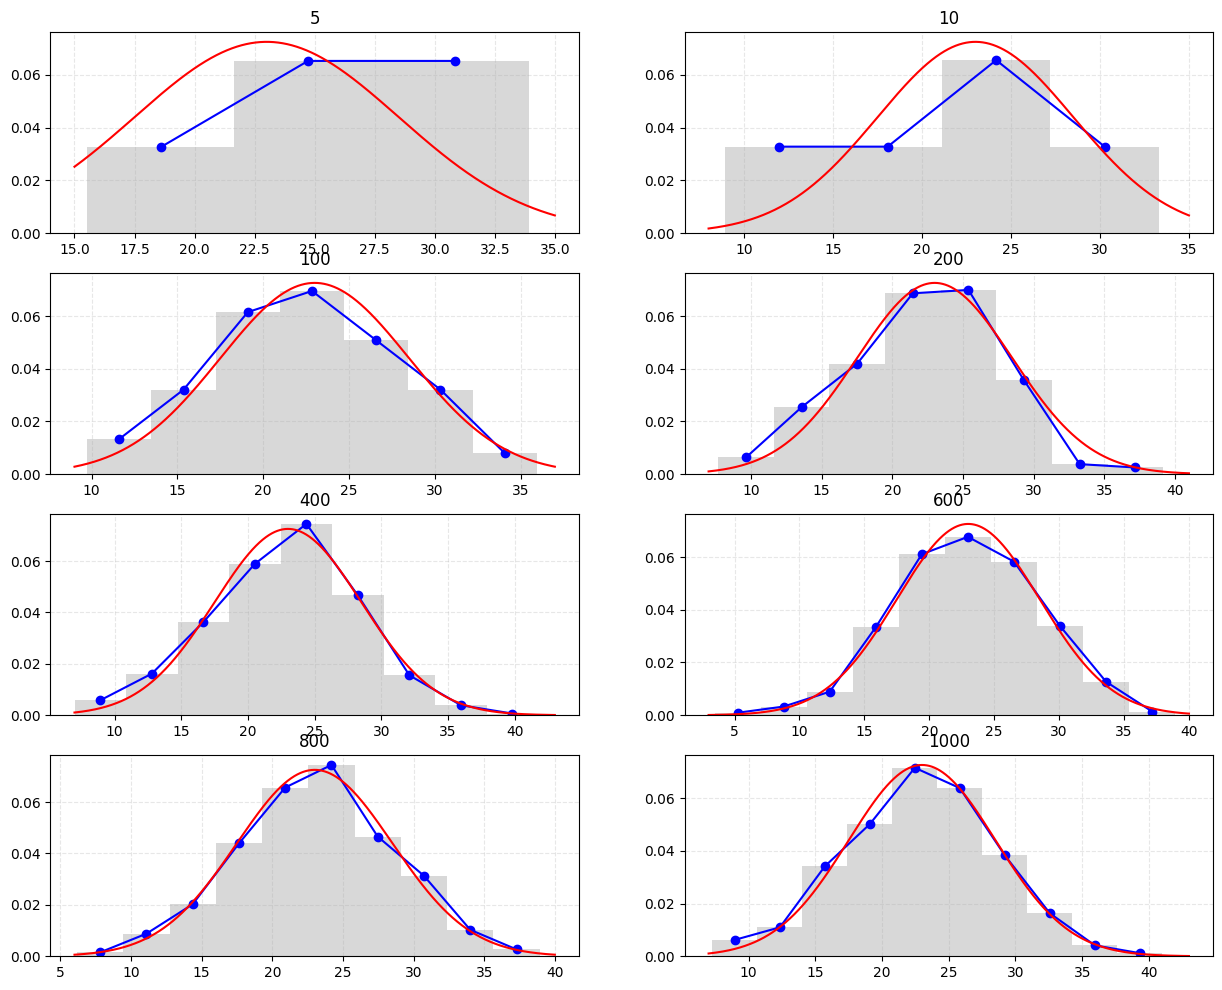

In [6]:
n_array = [5, 10, 100, 200, 400, 600, 800, 1000]

samples_normal = [[] for i in range(len(n_array))]

figure, axis = plt.subplots(4, 2)

for i, n in enumerate(n_array):
    axis[i//2 %4, i % 2].set_title(n)
    
    for k in range(5):
        y = normal_uniform(mu, sigma, n)
        samples_normal[i].append(y)
    
    bins = int(1 + np.floor(np.log2(n)))
    # Создаем гистограмму
    counts, bin_edges = histogram(y, bins)
    
    # Вычисляем середины интервалов
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2


    bin_width = bin_edges[1] - bin_edges[0]
    
    # Нормализуем частоты для плотности вероятности
    counts_normalized = np.array(counts) / (n * bin_width)


    # Строим полигон частот
    axis[i//2 %4, i % 2].plot(bin_mids, counts_normalized, marker='o', linestyle='-', color='b')
    
    # Добавляем столбцы 
    axis[i//2 %4, i % 2].bar(bin_mids, counts_normalized, width=bin_edges[1] - bin_edges[0], alpha=0.3, color='gray')
    
    axis[i//2 %4, i % 2].grid(linestyle='--', alpha=0.3)

    # Рисуем функцию плотности
    x = np.arange(np.ceil(min(y-1)), np.ceil(max(y+1)),0.001)
    axis[i//2 %4, i % 2].plot(x, normal(mu, sigma, x), color='red',label='Функция плотности')


figure.set_figheight(12)
figure.set_figwidth(15)
plt.show()

### Эмпирическая функция распределения

In [7]:
for i in range(len(samples_normal)):
  samples_normal[i] = [ np.sort(sample) for sample in samples_normal[i]]

In [8]:
def emp_func(x, sample):
  if x < sample[0]:
    return 0
  if x >= sample[-1]:
    return 1
  return sum(1 for element in sample if element <= x)/len(sample)

In [9]:
samples_normal[0]

[array([17.63385793, 21.4742651 , 23.53290941, 23.84240606, 26.77617843]),
 array([10.29954646, 15.04149411, 18.12101426, 24.76423238, 25.68272701]),
 array([20.12074677, 20.14503395, 20.52188841, 22.97444777, 31.04718793]),
 array([22.6183339 , 23.27750587, 26.83872436, 28.08843586, 29.01798813]),
 array([15.53419616, 23.02939324, 24.84082179, 32.57240459, 33.91128275])]

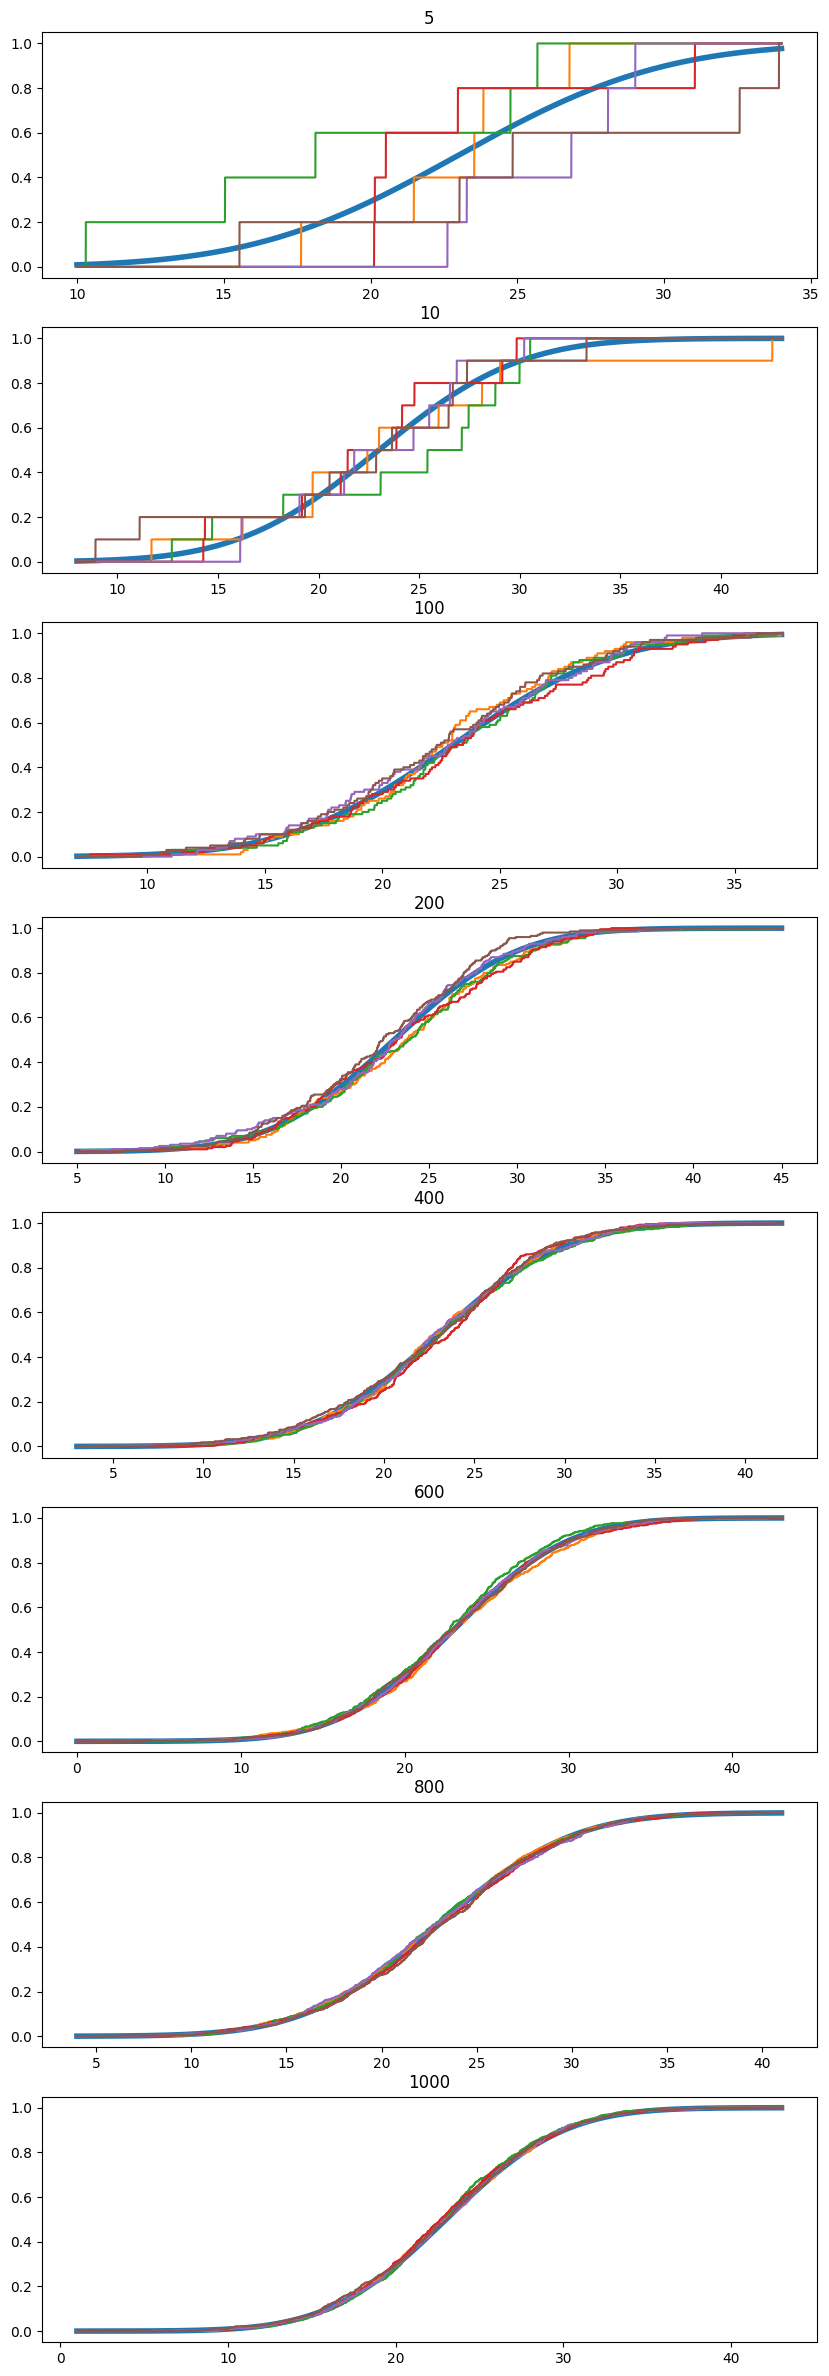

In [10]:
figure, axis = plt.subplots(8, 1)
emp_samples = [[] for i in range(len(samples_normal))]

for i, n in enumerate(n_array):
  axis[i].set_title(n)

  x = np.arange(np.floor(min(samples_normal[i][k][0] for k in range(5))), 
                np.ceil(max(samples_normal[i][k][-1] for k in range(5))),0.001)
  axis[i].plot(x, scipy.stats.norm.cdf(x, mu, sigma), linewidth = 4)

  for k in range(5):
    y = [emp_func(x_i, samples_normal[i][k]) for x_i in x]
    axis[i].plot(x, y)
figure.set_figheight(30)
figure.set_figwidth(10)
plt.show()


### $D_{nm}$

In [11]:
keys = [(n_array[i], n_array[j]) for i in range(len(n_array)) for j in range(i, len(n_array))]
dnm = {key: [] for key in keys}
for i in range(len(samples_normal)):
  to_dnm = []
  for j in range(i, len(samples_normal)):
    # print('\t', n_array[i], n_array[j])
    for k in range(5):
      sample1 = samples_normal[i][k]
      for l in range(k+1, 5):
        sample2 = samples_normal[j][l]
        n = n_array[i]
        m = n_array[j]
        diff = []
        for x in sample1:
          diff.append(np.abs(emp_func(x, sample1) - emp_func(x, sample2)))
        for x in sample2:
          diff.append(np.abs(emp_func(x, sample1) - emp_func(x, sample2)))
        dnm[(n_array[i], n_array[j])].append(np.sqrt((n*m) / (n+m)) * max(diff))

In [12]:
df = pd.DataFrame.from_dict(dnm, orient='index')
df.columns = [f'Value {i+1}' for i in range(df.shape[1])]
df

,Value 1,Value 2,Value 3,Value 4,Value 5,Value 6,Value 7,Value 8,Value 9,Value 10
"(5, 5)",0.632456,0.632456,0.948683,0.632456,0.948683,0.948683,0.632456,0.948683,0.948683,0.632456
"(5, 10)",0.912871,0.547723,0.547723,0.365148,0.730297,0.730297,0.730297,0.547723,0.547723,0.730297
"(5, 100)",0.545545,0.632832,0.523723,0.480079,0.916515,0.829228,0.851050,0.720119,0.763763,1.112911
"(5, 200)",0.662589,0.684675,0.519028,0.496942,0.894495,0.883452,0.828236,0.673632,0.750934,1.159531
"(5, 400)",0.594444,0.627778,0.522222,0.555556,0.950000,0.944444,0.872222,0.650000,0.688889,1.011111
"(5, 600)",0.482475,0.545568,0.549280,0.560414,0.924126,0.931548,0.883301,0.675465,0.694022,1.083714
"(5, 800)",0.554492,0.587929,0.576783,0.579569,0.933441,0.894432,0.950159,0.707743,0.685452,1.039324
"(5, 1000)",0.501862,0.533089,0.546472,0.544242,0.907813,0.921196,0.865433,0.664689,0.684763,1.055026
"(10, 10)",0.670820,0.447214,0.447214,0.447214,0.894427,0.894427,0.670820,0.447214,0.447214,0.447214
"(10, 100)",0.512569,0.361814,0.331662,0.482418,0.783929,0.874383,0.964836,0.452267,0.422116,0.482418


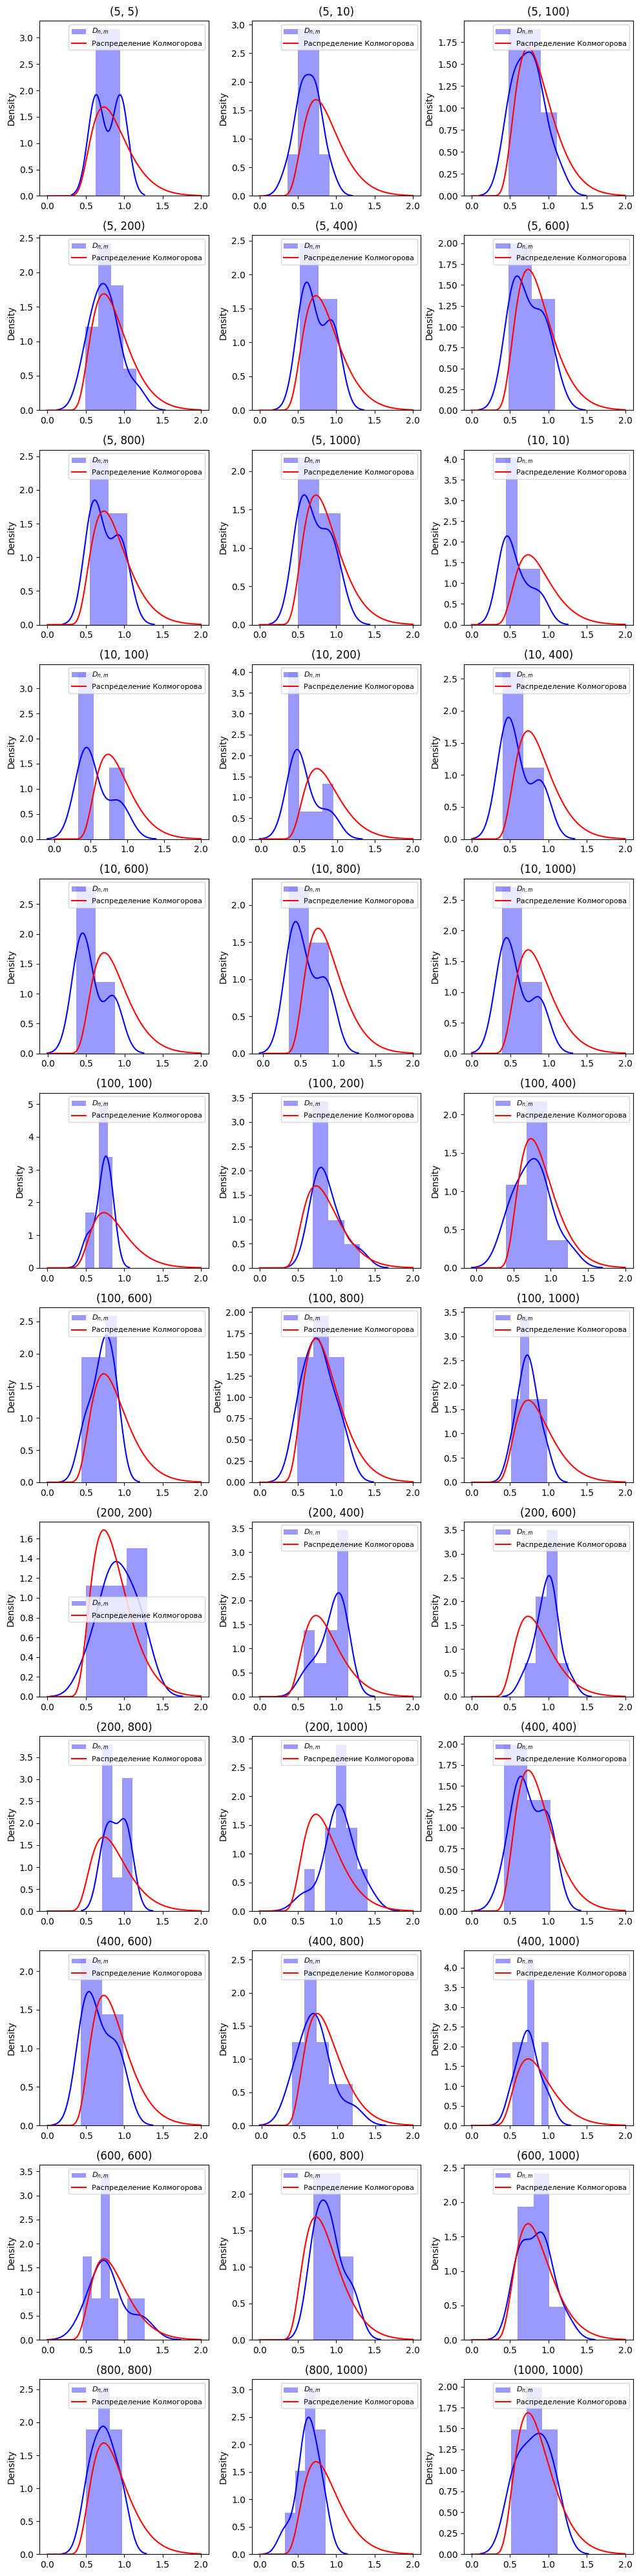

In [13]:
plt.figure(figsize=(10, 40))
for i in range(36):
  plt.subplot(12, 3, i + 1)
  x_array = np.linspace(0, 2, 1000)
  plt.title(keys[i])
  seaborn.distplot(dnm[keys[i]], label = '$D_{n,m}$', color='blue')
  plt.plot(x_array, scipy.stats.kstwobign.pdf(x_array), label='Распределение Колмогорова', color = 'red')
  plt.legend(fontsize = 8)
plt.tight_layout()
plt.show()

## Выборочные моменты

In [14]:
for i in range(len(samples_normal)):
  print(f"Sample {n_array[i]}")
  print("A_1       S^2")
  for j in range(5):
    print(f"{sum(samples_normal[i][j])/len(samples_normal[i][j]):.3f}", "  " , f"{sum((samples_normal[i][j] - sum(samples_normal[i][j])/len(samples_normal[i][j]))**2)/len(samples_normal[i][j]):.3f}")
  print('\n')

Sample 5
A_1       S^2
22.652    9.154
18.782    33.957
22.962    17.467
25.968    6.603
25.978    45.097


Sample 10
A_1       S^2
23.840    64.166
23.800    37.201
22.210    25.476
22.819    20.248
22.023    50.089


Sample 100
A_1       S^2
22.746    24.720
23.192    26.941
23.325    32.328
22.630    28.959
22.406    29.536


Sample 200
A_1       S^2
23.562    31.797
23.467    35.452
23.357    32.862
22.750    34.345
22.323    27.880


Sample 400
A_1       S^2
22.946    28.222
23.271    30.848
23.072    26.765
22.933    29.736
22.746    31.418


Sample 600
A_1       S^2
23.233    33.735
22.540    29.252
23.086    31.753
22.989    30.672
22.955    31.084


Sample 800
A_1       S^2
22.873    30.221
22.937    30.324
23.126    30.378
22.948    31.480
23.155    29.395


Sample 1000
A_1       S^2
22.948    29.918
22.876    27.135
22.855    30.354
23.016    29.557
22.864    30.950




# Логарифмическое распределение

In [15]:
def logarithmic_uniform(n, theta):
    u = np.random.uniform(size=n)

    N = int(np.ceil(-16 / np.log10(theta)))
    k = np.arange(1, N + 1)

    a = -1 / np.log(1 - theta)
    fk = np.exp(np.log(a) + k * np.log(theta) - np.log(k))
    Fk = np.cumsum(fk)

    x = np.zeros(n, dtype=int)

    for i in range(n):
        x[i] = np.sum(Fk < u[i])

    return x + 1

In [16]:
def logarithmic(theta, x):
  return (-1 / np.log(1 - theta)) * theta ** x / x

## Плотность распределения и полигоны частот

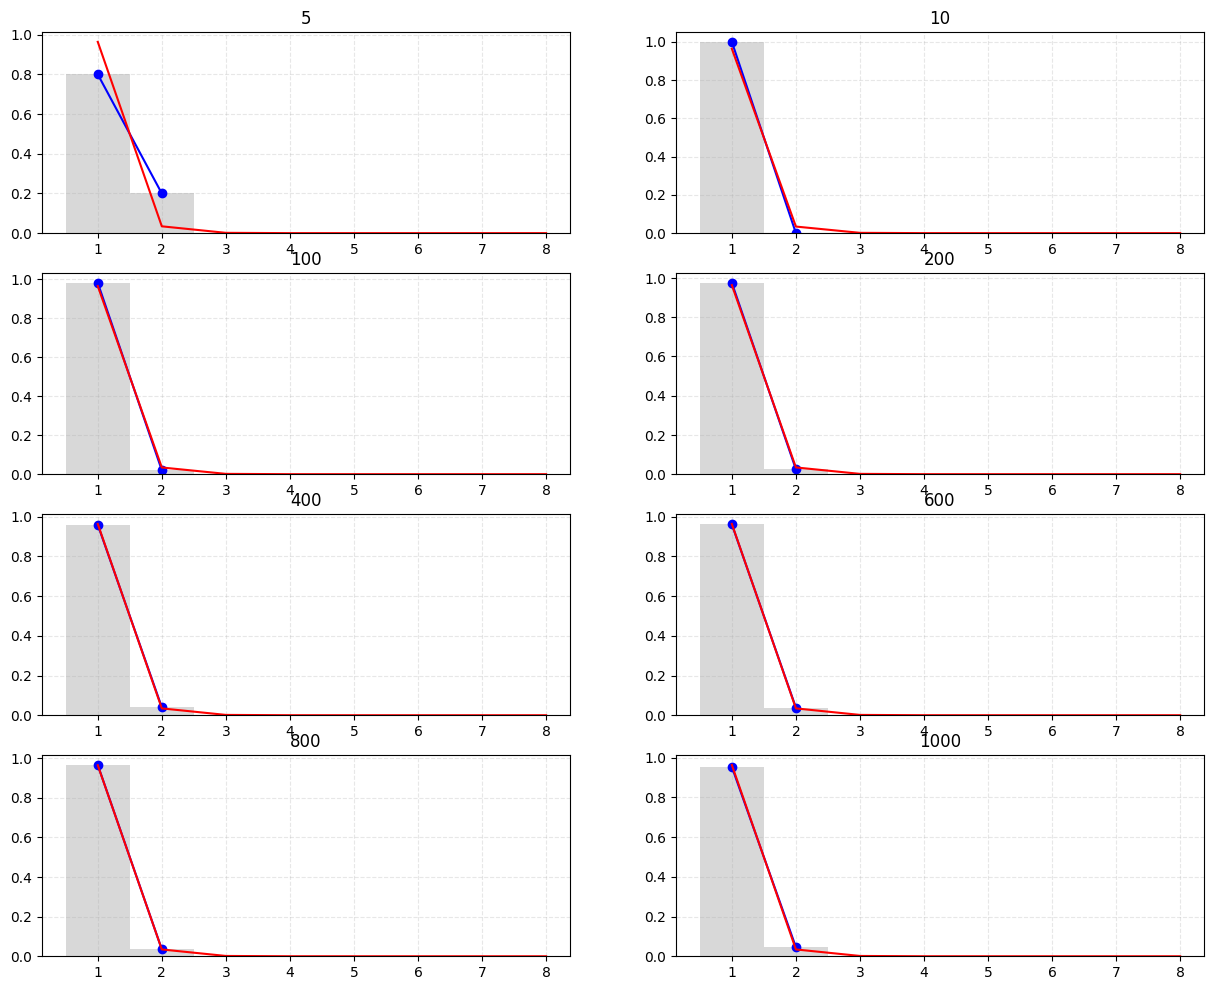

In [17]:
n_array = [5, 10, 100, 200, 400, 600, 800, 1000]

figure, axis = plt.subplots(4, 2)
samples_log = [[] for n in n_array]
theta = 1/14

for i, n in enumerate(n_array):
    axis[i//2 %4, i % 2].set_title(n)
    
    for k in range(5):
        y = logarithmic_uniform(n, theta)
        samples_log[i].append(y)
    
    bins = np.arange(1, 4)
    # Создаем гистограмму
    counts, bin_edges = histogram(y, bins)

    bin_width = bin_edges[1] - bin_edges[0]

    # Нормализуем частоты для плотности вероятности
    counts_normalized = np.array(counts) / (n * bin_width)

    # Строим полигон частот
    axis[i//2 %4, i % 2].plot(bin_edges[:-1], counts_normalized, marker='o', linestyle='-', color='b')

    # Добавляем столбцы 
    axis[i//2 %4, i % 2].bar(bin_edges[:-1], counts_normalized, width=bin_edges[1] - bin_edges[0], alpha=0.3, color='gray')

    axis[i//2 %4, i % 2].grid(linestyle='--', alpha=0.3)

    x = np.arange(1, 9)
    axis[i//2 %4, i % 2].plot(x, -1 / np.log(1 - theta) * theta ** x / x, color='red',label='Функция плотности')


figure.set_figheight(12)
figure.set_figwidth(15)
plt.show()

## Эмпирическая функция распределения

In [18]:
samples_log = [ np.sort(sample) for sample in samples_log]

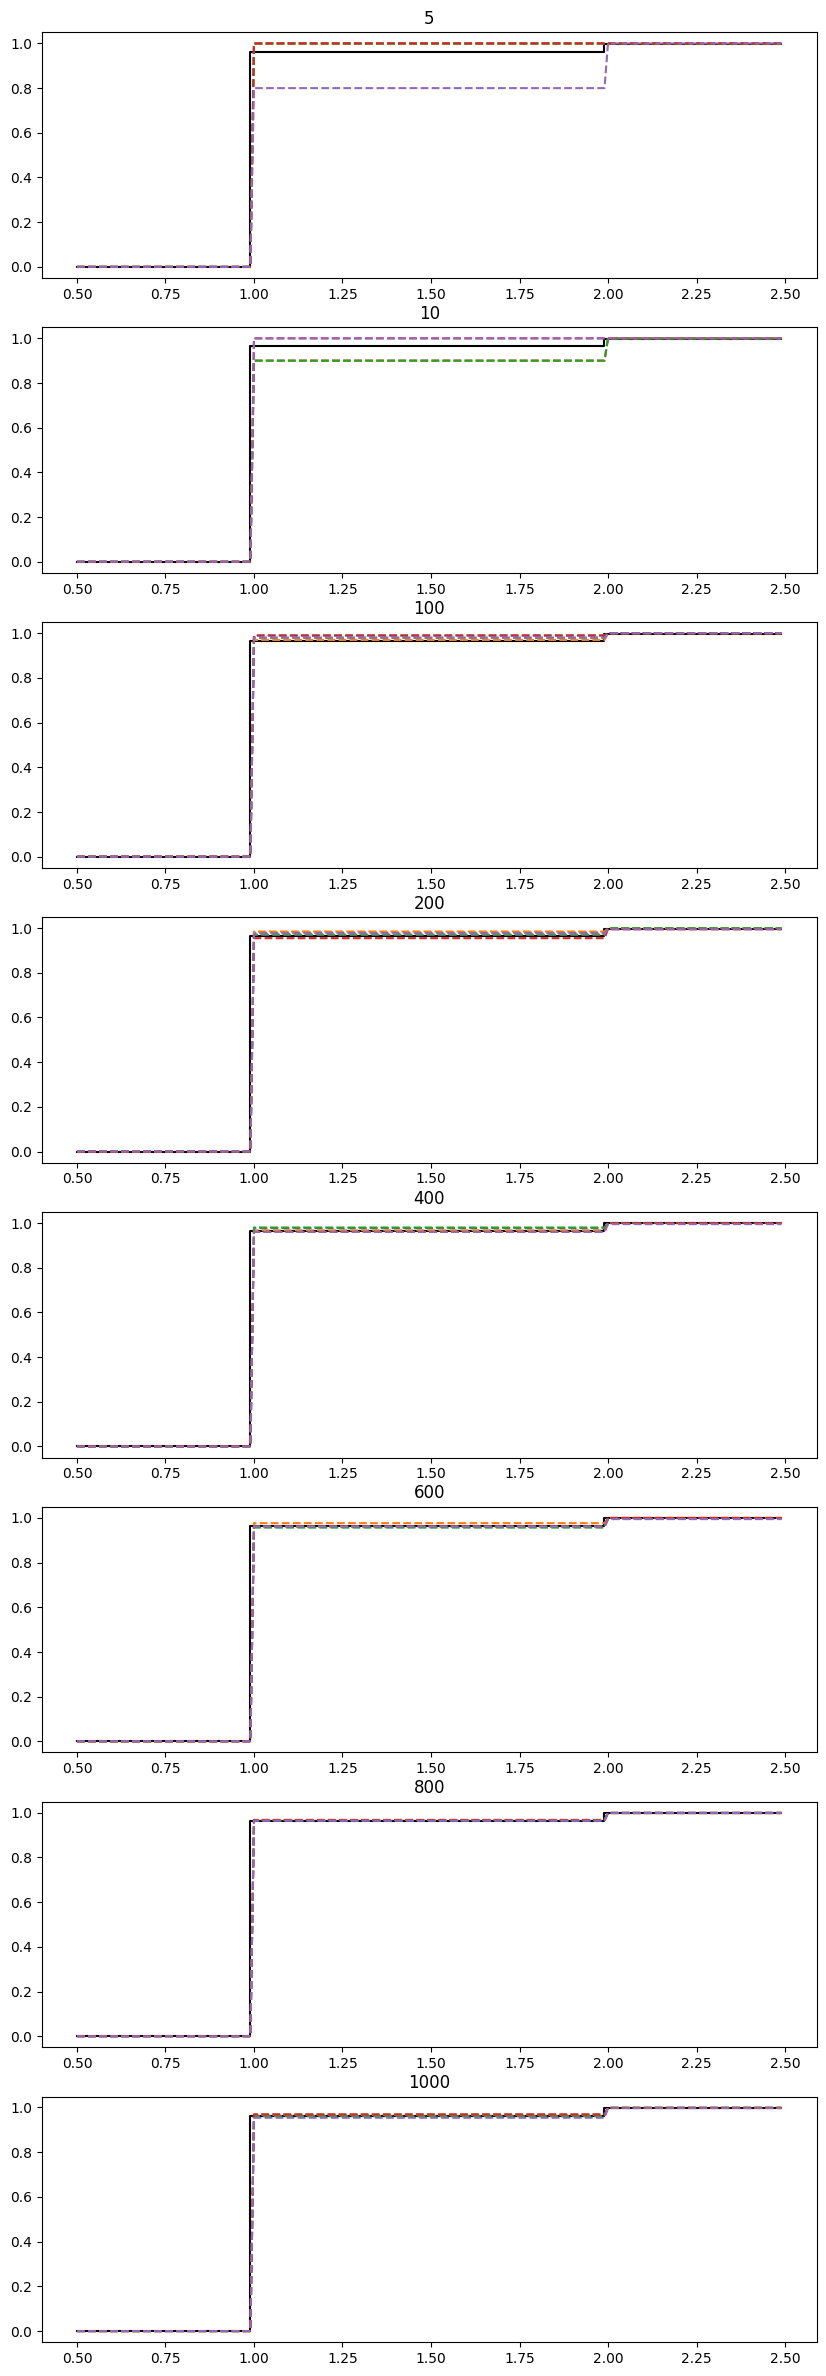

In [19]:
figure, axis = plt.subplots(8, 1)

for i, n in enumerate(n_array):
  axis[i].set_title(n)

  x = np.arange(0.5, 2.5 ,0.01)
  axis[i].step(x, scipy.stats.logser.cdf(x, theta), color = 'black')

  for k in range(5):
    y = [emp_func(x_i, samples_log[i][k]) for x_i in x]
    axis[i].plot(x, y, linestyle = '--')
figure.set_figheight(30)
figure.set_figwidth(10)
plt.show()

## Выборочные моменты

In [20]:
for i in range(len(samples_log)):
  print(f"Sample {n_array[i]}")
  print("A_1       S^2")
  for j in range(5):
    print(f"{sum(samples_log[i][j])/len(samples_log[i][j]):.3f}", "  " , f"{sum((samples_log[i][j] - sum(samples_log[i][j])/len(samples_log[i][j]))**2)/len(samples_log[i][j]):.3f}")
  print('\n')

Sample 5
A_1       S^2
1.000    0.000
1.000    0.000
1.000    0.000
1.000    0.000
1.200    0.160


Sample 10
A_1       S^2
1.100    0.090
1.100    0.090
1.100    0.090
1.000    0.000
1.000    0.000


Sample 100
A_1       S^2
1.010    0.010
1.030    0.029
1.020    0.020
1.010    0.010
1.020    0.020


Sample 200
A_1       S^2
1.020    0.020
1.015    0.015
1.030    0.029
1.050    0.058
1.030    0.039


Sample 400
A_1       S^2
1.022    0.022
1.032    0.031
1.020    0.020
1.040    0.038
1.045    0.053


Sample 600
A_1       S^2
1.042    0.047
1.023    0.023
1.048    0.056
1.037    0.035
1.043    0.051


Sample 800
A_1       S^2
1.036    0.035
1.032    0.034
1.034    0.035
1.032    0.031
1.036    0.037


Sample 1000
A_1       S^2
1.034    0.037
1.034    0.035
1.040    0.040
1.033    0.036
1.049    0.053




## $D_{n,m}$

In [21]:
keys = [(n_array[i], n_array[j]) for i in range(len(n_array)) for j in range(i, len(n_array))]
dnm = {key: [] for key in keys}
for i in range(len(samples_log)):
  to_dnm = []
  for j in range(i, len(samples_log)):
    # print('\t', n_array[i], n_array[j])
    for k in range(5):
      sample1 = samples_log[i][k]
      for l in range(k+1, 5):
        sample2 = samples_log[j][l]
        n = n_array[i]
        m = n_array[j]
        diff = []
        for x in sample1:
          diff.append(np.abs(emp_func(x, sample1) - emp_func(x, sample2)))
        for x in sample2:
          diff.append(np.abs(emp_func(x, sample1) - emp_func(x, sample2)))
        dnm[(n_array[i], n_array[j])].append(np.sqrt((n*m) / (n+m)) * max(diff))

In [22]:
df = pd.DataFrame.from_dict(dnm, orient='index')
df.columns = [f'Value {i+1}' for i in range(df.shape[1])]
df

,Value 1,Value 2,Value 3,Value 4,Value 5,Value 6,Value 7,Value 8,Value 9,Value 10
"(5, 5)",0.000000,0.000000,0.000000,0.316228,0.000000,0.000000,0.316228,0.000000,0.316228,0.316228
"(5, 10)",0.182574,0.182574,0.000000,0.000000,0.182574,0.000000,0.000000,0.000000,0.000000,0.000000
"(5, 100)",0.065465,0.043644,0.021822,0.043644,0.043644,0.021822,0.043644,0.021822,0.043644,0.043644
"(5, 200)",0.033129,0.066259,0.099388,0.055216,0.066259,0.099388,0.055216,0.099388,0.055216,0.055216
"(5, 400)",0.072222,0.044444,0.088889,0.088889,0.044444,0.088889,0.088889,0.088889,0.088889,0.088889
"(5, 600)",0.051959,0.096495,0.081650,0.085361,0.096495,0.081650,0.085361,0.081650,0.085361,0.085361
"(5, 800)",0.069660,0.072446,0.072446,0.078019,0.072446,0.072446,0.078019,0.072446,0.078019,0.078019
"(5, 1000)",0.073606,0.086989,0.069145,0.102603,0.086989,0.069145,0.102603,0.069145,0.102603,0.102603
"(10, 10)",0.000000,0.000000,0.223607,0.223607,0.000000,0.223607,0.223607,0.223607,0.223607,0.000000
"(10, 100)",0.211058,0.241209,0.271360,0.241209,0.241209,0.271360,0.241209,0.271360,0.241209,0.060302


# ДЗ 3

## Нормальное распределение

#### Метод моментов

$\hat{\theta}^{2} = \frac{1}{n} \sum_{i=1}^{n} (x_{i} - \mu)^{2} = \frac{1}{n} \sum_{i=1}^{n} (x_{i} - \overline{x})^{2} = S^{2}$

In [23]:
for i in range(len(samples_normal)):
  print(f"Sample {n_array[i]}")
  for j in range(5):
    print(f"{sum((samples_normal[i][j] - sum(samples_normal[i][j])/len(samples_normal[i][j]))**2)/len(samples_normal[i][j]):.3f}")
  print('\n')

Sample 5
9.154
33.957
17.467
6.603
45.097


Sample 10
64.166
37.201
25.476
20.248
50.089


Sample 100
24.720
26.941
32.328
28.959
29.536


Sample 200
31.797
35.452
32.862
34.345
27.880


Sample 400
28.222
30.848
26.765
29.736
31.418


Sample 600
33.735
29.252
31.753
30.672
31.084


Sample 800
30.221
30.324
30.378
31.480
29.395


Sample 1000
29.918
27.135
30.354
29.557
30.950




#### Метод максимального правдоподобия, Оптимальная оценка

$\hat\theta = \frac{1}{n} \sum_{i=1}^{n} (x-\mu)^{2}$

In [24]:
for i in range(len(samples_normal)):
  print(f"Sample {n_array[i]}")
  for j in range(5):
    hat_theta = 0
    for x in samples_normal[i][j]:
      hat_theta += (x - mu) ** 2
    hat_theta /= n
    print(f"{hat_theta:.3f}")
  print('\n')

Sample 5
0.046
0.259
0.087
0.077
0.270


Sample 10
0.649
0.378
0.261
0.203
0.510


Sample 100
2.478
2.698
3.243
2.910
2.989


Sample 200
6.423
7.134
6.598
6.881
5.668


Sample 400
11.290
12.369
10.708
11.896
12.593


Sample 600
20.274
17.678
19.056
18.403
18.652


Sample 800
24.190
24.262
24.315
25.186
23.535


Sample 1000
29.920
27.151
30.375
29.557
30.968




## Логарифмическое распределение

#### Метод максимального правдоподобия

Была получена оценка
$\hat{\theta} = \left({\overline{x} W\left(\frac{\exp\left(\frac{-1}{x}\right)}{-\overline{x}}\right)}\right)^{-1}  + 1$

В силу сложности подсчета функции Ламберта посчитаем не конкретно такое значение. Было получено, что $\overline{x} = \frac{-\hat\theta}{(1-\hat\theta)\ln(1-\hat\theta)}$. Сравним $\overline{x}$ и $\frac{-\theta}{(1-\theta)\ln(1-\theta)}$


In [25]:
for i in range(len(samples_log)):
  print(f"Sample {n_array[i]}")
  for j in range(5):
    print(f"{samples_log[i][j].mean():.5f}  {-theta / ((1-theta)*np.log(1-theta)):.5f}")
  print('\n')

Sample 5
1.00000  1.03799
1.00000  1.03799
1.00000  1.03799
1.00000  1.03799
1.20000  1.03799


Sample 10
1.10000  1.03799
1.10000  1.03799
1.10000  1.03799
1.00000  1.03799
1.00000  1.03799


Sample 100
1.01000  1.03799
1.03000  1.03799
1.02000  1.03799
1.01000  1.03799
1.02000  1.03799


Sample 200
1.02000  1.03799
1.01500  1.03799
1.03000  1.03799
1.05000  1.03799
1.03000  1.03799


Sample 400
1.02250  1.03799
1.03250  1.03799
1.02000  1.03799
1.04000  1.03799
1.04500  1.03799


Sample 600
1.04167  1.03799
1.02333  1.03799
1.04833  1.03799
1.03667  1.03799
1.04333  1.03799


Sample 800
1.03625  1.03799
1.03250  1.03799
1.03375  1.03799
1.03250  1.03799
1.03625  1.03799


Sample 1000
1.03400  1.03799
1.03400  1.03799
1.04000  1.03799
1.03300  1.03799
1.04900  1.03799




#### Метод моментов

оценка, полученная методом моментов совпадает с оценкой, полученной методом максимального правдоподобия

# дз 4

## Нормальное распределение

#### Критерий согласия Колмогорова

$D_n = sup_{-\infty < x < +\infty} | \hat F_n(x) - F(x)| $

Теорема Колмогорова (для непрерывных распределений и объема выборки $n \geq 20$):
$$P(\sqrt{n} D_n \geq \lambda_\alpha | H_0) \approx 1- K(\lambda_\alpha) = \alpha$$


Критерий согласия Колмогорова: если $n \geq 20$, выбран уровень значимость $\alpha$, по которому определяется $\lambda_\alpha : K(\lambda_\alpha) = 1- \alpha$, то
$$H_0 \text{ отвергается } \iff \sqrt{n} D_n \geq \lambda_\alpha$$

При малых объемах выборки ($n < 20$) исполоьзуем статистику $S_n = \frac{6nD_n + 1}{6 \sqrt{n}}$, которая также имеет распределение Колмогорова, но сходится к нему быстрее.

In [26]:
# посчитаем D_n для сгенерированных выборок
dn = []
for i in range(len(samples_normal)):
    to_dn = []
    for k in range(5):
        sample = np.hstack(([samples_normal[i][k][0] - 1], samples_normal[i][k], [samples_normal[i][k][-1] + 1]))
        n = n_array[i]
        diff = []
        for j in range(1, len(sample)):
            diff.append(np.abs(emp_func(sample[j-1], samples_normal[i][k]) - scipy.stats.norm.cdf(sample[j], mu, sigma)))
            diff.append(np.abs(emp_func(sample[j], samples_normal[i][k]) - scipy.stats.norm.cdf(sample[j], mu, sigma)))
        to_dn.append(max(diff))
    dn.append(to_dn)

Используемые уровни значимости $\alpha$ и соответствующие им значения $\lambda_\alpha$:
|$\alpha$| $\lambda_\alpha$ |
|-----|---------|
| 0.01| 1.62762 |
| 0.05| 1.3581  |
| 0.1 | 1.22385 |

Применим критерий к каждой сгенерированной выборке:

In [27]:
stat = []
for i in range(len(dn)):
    n = n_array[i]
    to_stat = []
    for j in range(5):
        if n < 20:
            to_stat.append((6 * n * dn[i][j] + 1)/(6 * np.sqrt(n)))
        else:
            to_stat.append(np.sqrt(n) * dn[i][j])
    stat.append(to_stat)

In [28]:
from IPython.display import display, HTML
alphas = [0.01, 0.05, 0.1]
lambdas = [scipy.stats.kstwobign.ppf(1-alpha) for alpha in alphas]
stat = np.array(stat).flatten()
stat_bin = []
for lambda_ in lambdas:
    to_stat_bin = []
    for x in stat:
        if x < lambda_:
            to_stat_bin.append(f'<span style="color: lightgreen ;;">{x}</span>')
        else:
            to_stat_bin.append(f'<span style="color: red;">{x}</span>')
    stat_bin.append(to_stat_bin)
df_stat = pd.DataFrame(np.array(stat_bin)).transpose()
df_stat.columns = [np.round(lambda_, 6) for lambda_ in lambdas]
df_stat.index = [f'{n_array[i]}_{j+1}' for i in range(8) for j in range(5)]


df_stat = df_stat.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}
])


display(HTML(df_stat.to_html(escape=False)))

,1.627624,1.358099,1.223848
5_1,0.6249982486373864,0.6249982486373864,0.6249982486373864
5_2,0.9968785848132676,0.9968785848132676,0.9968785848132676
5_3,0.7495003731692779,0.7495003731692779,0.7495003731692779
5_4,1.1307156259326105,1.1307156259326105,1.1307156259326105
5_5,0.8775274230832771,0.8775274230832771,0.8775274230832771
10_1,0.44935253406300046,0.44935253406300046,0.44935253406300046
10_2,0.9153450707559141,0.9153450707559141,0.9153450707559141
10_3,0.6039286023287169,0.6039286023287169,0.6039286023287169
10_4,0.4990038855270424,0.4990038855270424,0.4990038855270424
10_5,0.6366925711952311,0.6366925711952311,0.6366925711952311


#### Критерий согласия хи-квадрат


Разобьем множество возможных значений наблюдаемой величины на $N$ непересекающихся подмножеств: $\varepsilon_{1,}..., \varepsilon_{N}$ и пусть $v_{i}$ - число элементов выборки, попавших в интервал $\varepsilon_{i}$, $i=\overline{1,N}$. Обозначим через $p_{j}(\theta)$ теоретическую вероятность попадания в $\varepsilon_{i}, \ i = \overline{1, N}$. 

Поскольку относительная частота $\frac{v_{i}}{n}$ попадания в интервал $\varepsilon_{i}$ является состоятельной оценкой вероятность $p_{i}(\theta)$, то одной из возможных мер отклонения выборочных данных от теоретических значений может быть мера хи-квадрат:
$$\chi^ {2}_{n}= \sum_{i=1}^{N} \frac{n}{p_{i}(\theta)} \left(\frac{v_{i}}{n} - p_{i}(\theta)\right)^{2} = \sum_{i=1}^{N} \frac{v_{i}^{2}}{np_{i}(\theta)} - n $$
Так как, еще раз, относительная частота $\frac{v_{i}}{n}$ попадания в интервал $\varepsilon_{i}$ является состоятельной оценкой вероятности $p_{i}(\theta)$, то при больших $n$ разности $\left| \frac{v_{i}}{n} - p_{i}(\theta)\right|$ должны быть малы, следовательно, и значение статистики $\chi^{2}_{n}$ не должно быть слишком большим. Поэтому задается критическая область для гипотезы $H_{0}$ в виде $\mathcal{T} _{1\alpha} = \{ \chi^{2}_{n} > t_{\alpha} \}$, где критическая граница ${} t_{\alpha} {}$ при заданном уровне значимости $\alpha$ должна быть выбрана из условия:
$$P(\chi^{2}_{n} > t_{a} | H_{0}) = \alpha$$
Для вычисления границы $t_\alpha$ надо знать распределение статистики $\chi^{2}_{n}$ при нулевой гипотезе $H_{0}$, что проблематично, поэтому пользуются теоремой:
$$
\begin{aligned}
\text{Если} \quad 0<p_{j} &(\theta)<1,  \ j=\overline{1,N}, \quad \text{то при } \quad n \rightarrow \infty \\
&\\
& \mathcal{L}(\chi^{2}_{n} | H_{0}) \rightarrow \chi^{2} (N-1)
\end{aligned}
$$

На практике предельное распределение $\chi^{2} (N-1)$ можно использовать для расчетов с хорошим приближением уже при $n \geq 50$ и $v_{i} \geq 5$. При выполнении этих условий можно записать, что $P(\chi^{2}_{n} > t_{\alpha}| H_{0}) \approx 1-F_{N-1}(t_\alpha)$, где $F_{N-1}(t)$ - функция распределения $\chi^{2}(N-1)$. Следовательно, полагая 
$$
\begin{gather*}
1-F_{N-1}(t_{\alpha)}= \alpha \\
\text{т.е.} \ \ t_{\alpha}= \chi^{2}_{1-\alpha,N} \  - \  \text{(1-a)-квантиль распределения } \chi^{2}(N) 
\end{gather*}
$$
Таким образом критерий согласия имеет следующий вид: пусть объем выборки $n$ и частоты $v_{i}$ удовлетворяют условиям $n \geq 50, v_{j} \geq5$. Тогда при заданном уровне значимости $\alpha$:
$$
H_{0} \ \text{отвергается } \ \iff \chi^{2}_{n} > \chi^{2}_{1-\alpha,N} 
$$


In [79]:
# функция для подсчета chi^2_n
def chi_2_n(data, N):
    n = len(data)
    counts, borders = histogram(data, N)
    borders[0] = -np.inf
    borders[-1] = np.inf
    p = [] # вероятности
    for b in range(1, len(borders)):
        p.append(scipy.integrate.quad(lambda x: normal(mu, sigma, x), borders[b-1],borders[b])[0])
    return sum([n / p[i] * (counts[i]/n - p[i]) **2  for i in range(len(counts))])

In [80]:
# функция для подсчета квантиля
def chi_2_a(a, N):
    return scipy.stats.chi2.ppf(1 - a, N)

In [81]:
chi_2_n_array = [] # массив со значениями статистики хи квадрат
chi_2_N_array = [] # массив с квантилями
N_array = [] # массив со значениями N
alphas = [0.01, 0.05, 0.1]
for i in range(len(samples_normal)):
    n = n_array[i]
    optimal_N =  int(1 + np.floor(np.log2(n)))
    Ns = [int(np.ceil(optimal_N/2)), int(optimal_N), int(np.ceil(1.5 * optimal_N))]
        
    for j in range(5):
        chi_2_n_array.append([chi_2_n(samples_normal[i][j], N) for N in Ns])

        chi_2_N_array.append([chi_2_a(a,N) for N in Ns for a in alphas])
        N_array.append(Ns)

In [82]:
chi_2_N_df = pd.DataFrame(chi_2_N_array)
chi_2_N_df.columns = [f'a={a} N{j}'for j in range(1,4) for a in alphas ]

chi_2_n_df = pd.DataFrame(chi_2_n_array)
chi_2_n_df.columns = [f'χ²ₙ N{i}' for i in range(1,4)]

N_df = pd.DataFrame(N_array)
N_df.columns = ['N_1 = ⌈N/2⌉', 'N_2 = N', 'N_3 = ⌈N*1.5⌉']


In [83]:
for column in chi_2_N_df.columns:
    for index in chi_2_N_df.index:
        if chi_2_n_df[f'χ²ₙ N{column[-1]}'][index] > chi_2_N_df[column][index]: #отвергается
            chi_2_N_df[column][index] = f'<span style="color: red ;;">{chi_2_n_df[f'χ²ₙ N{column[-1]}'][index]:.4f}</span>/ {chi_2_N_df[column][index]:.4f}'
        else:
            chi_2_N_df[column][index] = f'<span style="color: lightgreen ;;">{chi_2_n_df[f'χ²ₙ N{column[-1]}'][index]:.4f}</span>/ {chi_2_N_df[column][index]:.4f}'


chi_2_N_df.index = [f'{n_array[i]}_{j+1}' for i in range(8) for j in range(5)]
for column in N_df.columns:
    chi_2_N_df[column] = N_df[column].values

In [84]:
chi_2_N_df = chi_2_N_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}
])

display(HTML(chi_2_N_df.to_html(escape=False)))

,a=0.01 N1,a=0.05 N1,a=0.1 N1,a=0.01 N2,a=0.05 N2,a=0.1 N2,a=0.01 N3,a=0.05 N3,a=0.1 N3,N_1 = ⌈N/2⌉,N_2 = N,N_3 = ⌈N*1.5⌉
5_1,0.0367/ 9.2103,0.0367/ 5.9915,0.0367/ 4.6052,1.0856/ 11.3449,1.0856/ 7.8147,1.0856/ 6.2514,4.0195/ 15.0863,4.0195/ 11.0705,4.0195/ 9.2364,2,3,5
5_2,1.6128/ 9.2103,1.6128/ 5.9915,1.6128/ 4.6052,6.5030/ 11.3449,6.5030/ 7.8147,6.5030/ 6.2514,5.4656/ 15.0863,5.4656/ 11.0705,5.4656/ 9.2364,2,3,5
5_3,0.3271/ 9.2103,0.3271/ 5.9915,0.3271/ 4.6052,1.7093/ 11.3449,1.7093/ 7.8147,1.7093/ 6.2514,1.6713/ 15.0863,1.6713/ 11.0705,1.6713/ 9.2364,2,3,5
5_4,2.0671/ 9.2103,2.0671/ 5.9915,2.0671/ 4.6052,1.0942/ 11.3449,1.0942/ 7.8147,1.0942/ 6.2514,3.3759/ 15.0863,3.3759/ 11.0705,3.3759/ 9.2364,2,3,5
5_5,1.0581/ 9.2103,1.0581/ 5.9915,1.0581/ 4.6052,1.6390/ 11.3449,1.6390/ 7.8147,1.6390/ 6.2514,7.5167/ 15.0863,7.5167/ 11.0705,7.5167/ 9.2364,2,3,5
10_1,0.3046/ 9.2103,0.3046/ 5.9915,0.3046/ 4.6052,4.6473/ 13.2767,4.6473/ 9.4877,4.6473/ 7.7794,21.8351/ 16.8119,21.8351/ 12.5916,21.8351/ 10.6446,2,4,6
10_2,0.2510/ 9.2103,0.2510/ 5.9915,0.2510/ 4.6052,1.9896/ 13.2767,1.9896/ 9.4877,1.9896/ 7.7794,4.5383/ 16.8119,4.5383/ 12.5916,4.5383/ 10.6446,2,4,6
10_3,0.1885/ 9.2103,0.1885/ 5.9915,0.1885/ 4.6052,0.4826/ 13.2767,0.4826/ 9.4877,0.4826/ 7.7794,0.7152/ 16.8119,0.7152/ 12.5916,0.7152/ 10.6446,2,4,6
10_4,0.0054/ 9.2103,0.0054/ 5.9915,0.0054/ 4.6052,0.3757/ 13.2767,0.3757/ 9.4877,0.3757/ 7.7794,0.9831/ 16.8119,0.9831/ 12.5916,0.9831/ 10.6446,2,4,6
10_5,0.0501/ 9.2103,0.0501/ 5.9915,0.0501/ 4.6052,2.5069/ 13.2767,2.5069/ 9.4877,2.5069/ 7.7794,9.7314/ 16.8119,9.7314/ 12.5916,9.7314/ 10.6446,2,4,6


#### Критерий согласия Колмогорова (Смирнова) для сложной гипотезы (в условиях когда неизвестен параметр распределения)

В случае сложных гипотез распределение $D_{n}(\theta)$ зависит от вида априорных распределений, от способа получения оценок, размера выборки и от вида параметрического множества. Однако описанную ранее методику проверки гипотезы о виде распределения можно применить и в случае сложной гипотезу следующим образом.

Оценка методом максимального правдоподобия, полученная ранее:
$\hat{\theta}^{2} = S^{2}$
Вычислим значения статистики, соответствующей рассматриваемому критерию $\hat{D_{n}} = \sup_{x \in R} |\hat{F_{n}}(x) - F(x, \hat\theta)|$. При этом в случае достаточно большой выборки, можно разбить ее на две части: по одной получить оценки на неизвестные параметры, по второй проверить гипотезу о виде распределения.

In [35]:
import random
dn = [] # таблица с dn
for i in range(len(samples_normal)):
    to_dn = []# строка таблицы
    n = n_array[i]
    for k in range(5):
        sample = random.sample(list(samples_normal[i][k]), n)
        sample1 = sample[:n//2] # оценка sigma_
        sample2 = sample[n//2:] # проверка гипотезы
        sigma_ = np.sqrt(sum((sample1 - sum(sample1)/len(sample1))**2)/len(sample1)) # подсчет параметра
        diff = [] # массив с разницами 
        sample2.sort() 
        sample2_enchanced = np.hstack(([sample2[0] - 1], sample2, [sample[-1] + 1])) # добавляем два крайних значения для поиска супремума разницы
        for j in range(1, len(sample2)):
            diff.append(np.abs(emp_func(sample2_enchanced[j-1], sample2) - scipy.stats.norm.cdf(sample2_enchanced[j], mu, sigma_)))
            diff.append(np.abs(emp_func(sample2_enchanced[j], sample2) - scipy.stats.norm.cdf(sample2_enchanced[j], mu, sigma_)))
        to_dn.append(max(diff))# добавляем элемент в строку
    dn.append(to_dn) # добавляем строку в таблицу

Используемые уровни значимости $\alpha$ и соответствующие им значения $\lambda_\alpha$:
|$\alpha$| $\lambda_\alpha$ |
|-----|---------|
| 0.01| 1.62762 |
| 0.05| 1.3581  |
| 0.1 | 1.22385 |

Применим критерий к каждой сгенерированной выборке:

In [36]:
stat = []
for i in range(len(dn)):
    n = np.ceil(n_array[i]/2)
    to_stat = []
    for j in range(5):
        if n < 20:
            to_stat.append((6 * n * dn[i][j] + 1)/(6 * np.sqrt(n)))
        else:
            to_stat.append(np.sqrt(n) * dn[i][j])
    stat.append(to_stat)

In [37]:
from IPython.display import display, HTML
alphas = [0.01, 0.05, 0.1]
lambdas = [scipy.stats.kstwobign.ppf(1-alpha) for alpha in alphas]
stat = np.array(stat).flatten()
stat_bin = []
for lambda_ in lambdas:
    to_stat_bin = []
    for x in stat:
        if x < lambda_:
            to_stat_bin.append(f'<span style="color: lightgreen ;;">{x}</span>')
        else:
            to_stat_bin.append(f'<span style="color: red;">{x}</span>')
    stat_bin.append(to_stat_bin)
df_stat = pd.DataFrame(np.array(stat_bin)).transpose()
df_stat.columns = [np.round(lambda_, 6) for lambda_ in lambdas]
df_stat.index = [f'{n_array[i]}_{j+1}' for i in range(8) for j in range(5)]


df_stat = df_stat.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}
])


display(HTML(df_stat.to_html(escape=False)))

,1.627624,1.358099,1.223848
5_1,0.8931497580550551,0.8931497580550551,0.8931497580550551
5_2,0.9776426231624378,0.9776426231624378,0.9776426231624378
5_3,0.6885371971312557,0.6885371971312557,0.6885371971312557
5_4,0.7742151458709633,0.7742151458709633,0.7742151458709633
5_5,0.9646345428181896,0.9646345428181896,0.9646345428181896
10_1,0.922535972961181,0.922535972961181,0.922535972961181
10_2,0.5320301895587842,0.5320301895587842,0.5320301895587842
10_3,0.6237204489230604,0.6237204489230604,0.6237204489230604
10_4,1.0176781642156425,1.0176781642156425,1.0176781642156425
10_5,0.9482621533111366,0.9482621533111366,0.9482621533111366


#### Критерий согласия хи-квадрат для сложной гипотезы (в условиях, когда неизвестен параметр распределения)



Также, как и в случае с простой гипотезой построим $\chi^{2}_{n} (\theta) = \sum_{i=1}^{n} \frac{(v_{i} - np_{i}(\theta))^{2}}{np_{i}(\theta)}$. Эта статистика зависит от неизвестного параметра, поэтому непосредственно ее использовать нельзя - требуется предварительно исключить неопределённость в $\theta$. Для этого заменяют $\theta$ некоторой оценкой $\hat{\theta}$ и получают в итоге статистику $\hat{\chi}^{2}_{n} = \chi^{2}_{n}(\hat{\theta})$. Это уже функция только от наблюдений, следовательно, ее значение можно однозначно вычислить для каждой реализации. Однако, чтобы рассчитать соответствующий критерий, надо знать распределение $\hat{\chi}^{2}_{n}$ при гипотезе $H_{0}$. Положение осложняется тем, что теперь величины $p_{i}(\hat{\theta})$ теперь уже не постоянные, а представляют собой функции от наблюдений, поэтому подход, как в случае простой гипотезы здесь неприменим. 

Проблема нахождения предельного распределения $\hat{\chi}^{2}_{n}$ решается тем, что существуют методы оценивания параметра $\theta$, при которых это предельное распределение имеет простой вид, а именно, является распределением ${\chi}^{2}_{N-1-r}$. В частности, это будет иметь место при использовании оценки максимального правдоподобия.

**Теорема** Пусть функции $p_j(\theta) , \ j = 1, \dots, N$, удовлетворяют условиям:

1) $\left(\sum_{j=1}^{N} p_j(\theta) = 1\right), \forall \theta \in \Theta$;

2) $p_j(\theta) \geq c > 0 , \forall j$, и существуют непрерывные производные
$\frac{\partial p_j(\theta)}{\partial \theta_k}, \quad \frac{\partial^2 p_j(\theta)}{\partial \theta_k \partial \theta_l}, \quad k, l = 1, \dots, r;$

3) $(N \times r)-\text{матрица} \left\lVert \frac{\partial p_j(\theta)}{\partial \theta_k} \right\rVert\ \text{имеет ранг} \ \   r  \ \ \text{для всех} \ \ \theta \in \Theta$

Тогда
$C(\hat{\chi}_n^2 | H_0) \to \chi^2{(N-1-r)}$


 При выполнении условий теоремы критерий имеет вид:
 $$H_{0} \ \ \text{отвергается} \iff \hat{\chi}^{2}_{n} > \chi^{2}_{1-\alpha,N-1-r}$$


In [85]:
# функция для подсчета chi^2_n
def chi_2_n(data, N, theta):
    n = len(data)
    counts, borders = histogram(data, N)
    borders[0] = -np.inf
    borders[-1] = np.inf
    p = [] # вероятности
    for b in range(1, len(borders)):
        p.append(scipy.integrate.quad(lambda x: normal(mu, theta, x), borders[b-1],borders[b])[0])
    return sum([n / p[i] * (counts[i]/n - p[i]) **2  for i in range(len(counts))])

In [86]:
# функция для подсчета квантиля
def chi_2_a(a, N):
    return scipy.stats.chi2.ppf(1 - a, N-2)

In [91]:
chi_2_n_array = [] # массив со значениями статистики хи квадрат
chi_2_N_array = [] # массив с квантилями
N_array = [] # массив со значениями N
alphas = [0.01, 0.05, 0.1]
for i in range(len(samples_normal)):
    n = n_array[i]
    optimal_N =  int(1 + np.floor(np.log2(n)))
    Ns = [int(np.ceil(optimal_N/2)) + 1, int(optimal_N), int(np.ceil(1.5 * optimal_N))]
        
    for j in range(5):
        sigma_ = np.sqrt(sum((samples_normal[i][j] - sum(samples_normal[i][j])/n)**2)/n) # подсчет параметра

        chi_2_n_array.append([chi_2_n(samples_normal[i][j], N, sigma_) for N in Ns])

        chi_2_N_array.append([chi_2_a(a,N) for N in Ns for a in alphas])
        N_array.append(Ns)

In [92]:
chi_2_N_df = pd.DataFrame(chi_2_N_array)
chi_2_N_df.columns = [f'a={a} N{j}'for j in range(1,4) for a in alphas ]

chi_2_n_df = pd.DataFrame(chi_2_n_array)
chi_2_n_df.columns = [f'χ²ₙ N{i}' for i in range(1,4)]

N_df = pd.DataFrame(N_array)
N_df.columns = ['N_1 = ⌈N/2⌉', 'N_2 = N', 'N_3 = ⌈N*1.5⌉']


In [93]:
for column in chi_2_N_df.columns:
    for index in chi_2_N_df.index:
        if chi_2_n_df[f'χ²ₙ N{column[-1]}'][index] > chi_2_N_df[column][index]: #отвергается
            chi_2_N_df[column][index] = f'<span style="color: red ;;">{chi_2_n_df[f'χ²ₙ N{column[-1]}'][index]:.4f}</span>/ {chi_2_N_df[column][index]:.4f}'
        else:
            chi_2_N_df[column][index] = f'<span style="color: lightgreen ;;">{chi_2_n_df[f'χ²ₙ N{column[-1]}'][index]:.4f}</span>/ {chi_2_N_df[column][index]:.4f}'


chi_2_N_df.index = [f'{n_array[i]}_{j+1}' for i in range(8) for j in range(5)]
for column in N_df.columns:
    chi_2_N_df[column] = N_df[column].values

In [94]:
chi_2_N_df = chi_2_N_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}
])

display(HTML(chi_2_N_df.to_html(escape=False)))

,a=0.01 N1,a=0.05 N1,a=0.1 N1,a=0.01 N2,a=0.05 N2,a=0.1 N2,a=0.01 N3,a=0.05 N3,a=0.1 N3,N_1 = ⌈N/2⌉,N_2 = N,N_3 = ⌈N*1.5⌉
5_1,0.0204/ 6.6349,0.0204/ 3.8415,0.0204/ 2.7055,0.0204/ 6.6349,0.0204/ 3.8415,0.0204/ 2.7055,1.8562/ 11.3449,1.8562/ 7.8147,1.8562/ 6.2514,3,3,5
5_2,5.2964/ 6.6349,5.2964/ 3.8415,5.2964/ 2.7055,5.2964/ 6.6349,5.2964/ 3.8415,5.2964/ 2.7055,4.4120/ 11.3449,4.4120/ 7.8147,4.4120/ 6.2514,3,3,5
5_3,1.9607/ 6.6349,1.9607/ 3.8415,1.9607/ 2.7055,1.9607/ 6.6349,1.9607/ 3.8415,1.9607/ 2.7055,2.6095/ 11.3449,2.6095/ 7.8147,2.6095/ 6.2514,3,3,5
5_4,9.4118/ 6.6349,9.4118/ 3.8415,9.4118/ 2.7055,9.4118/ 6.6349,9.4118/ 3.8415,9.4118/ 2.7055,24.3285/ 11.3449,24.3285/ 7.8147,24.3285/ 6.2514,3,3,5
5_5,1.1817/ 6.6349,1.1817/ 3.8415,1.1817/ 2.7055,1.1817/ 6.6349,1.1817/ 3.8415,1.1817/ 2.7055,5.2182/ 11.3449,5.2182/ 7.8147,5.2182/ 6.2514,3,3,5
10_1,0.2255/ 6.6349,0.2255/ 3.8415,0.2255/ 2.7055,1.1329/ 9.2103,1.1329/ 5.9915,1.1329/ 4.6052,2.1985/ 13.2767,2.1985/ 9.4877,2.1985/ 7.7794,3,4,6
10_2,2.3452/ 6.6349,2.3452/ 3.8415,2.3452/ 2.7055,1.3938/ 9.2103,1.3938/ 5.9915,1.3938/ 4.6052,3.8690/ 13.2767,3.8690/ 9.4877,3.8690/ 7.7794,3,4,6
10_3,0.2834/ 6.6349,0.2834/ 3.8415,0.2834/ 2.7055,0.3561/ 9.2103,0.3561/ 5.9915,0.3561/ 4.6052,1.0661/ 13.2767,1.0661/ 9.4877,1.0661/ 7.7794,3,4,6
10_4,0.0102/ 6.6349,0.0102/ 3.8415,0.0102/ 2.7055,0.5143/ 9.2103,0.5143/ 5.9915,0.5143/ 4.6052,0.6207/ 13.2767,0.6207/ 9.4877,0.6207/ 7.7794,3,4,6
10_5,0.0219/ 6.6349,0.0219/ 3.8415,0.0219/ 2.7055,0.9032/ 9.2103,0.9032/ 5.9915,0.9032/ 4.6052,4.1793/ 13.2767,4.1793/ 9.4877,4.1793/ 7.7794,3,4,6


#### Проверка гипотезы об однородности выборок


Как мы знаем, эмпирическая функция распределения является оптимальной оценкой для теоретической функции распределения, поэтому в случае справедливости гипотезы $H_{0}$ функции $\hat{F_{1}}(x)$ и $\hat{F_{2}}(x)$ оценивают одну и ту же неизвестную функцию распределения. Тем самым в этом случае (по крайней мере при больших n и m) статистика $D_{nm} = sup_{-\infty < x < \infty} | \hat{F}_{n}(x) - \hat{F}_{m}(x) |$ не должна существенно отклоняться от нуля. Поэтому разумно брать критическую границу в виде $\mathcal{T}_{\alpha}= \{D_{nm} > t_\alpha(n,m)\}$. Критическую границу $t_\alpha(n,m)$ при заданном уровне значимости $\alpha$ находят на основании известного при гипотезе $H_{0}$ предельного распределения статистики $D_{nm}$, даваемого теоремой Смирнова. На основании этой теоремы при больших $n$ и $m$ можно положить $t_{\alpha}(n, m) = \sqrt{\frac{1}{n} + \frac{1}{m}}\lambda_\alpha$, где $K(\lambda_{\alpha)}= 1-\alpha$. Действительно, в этом случае:
$$
P \left\{ D_{n,m} > \sqrt{\frac{1}{n} + \frac{1}{m}} \lambda_{\alpha} \mid H_0 \right\} = P \left\{ \sqrt{\frac{nm}{n+m}} D_{n,m} > \lambda_{\alpha} \mid H_0 \right\} \approx 1 - K(\lambda_{\alpha}) = \alpha.
$$

Итак асимптотический вариант критерия однородности Смирнова имеет вид:
$$
H_{0} \ \ \text{отвергается} \iff D_{nm} > \lambda_{\alpha}\sqrt{\frac{1}{n} + \frac{1}{m}}
$$

In [44]:
#функция для квантиля
def lambda_K(alpha):
    return scipy.stats.kstwobign.ppf(1-alpha)

In [45]:
# считаем dnm
keys = [(n_array[i], n_array[j]) for i in range(len(n_array)) for j in range(i, len(n_array))]
dnm = {key: [] for key in keys}
for i in range(len(samples_normal)):
  to_dnm = []
  for j in range(i, len(samples_normal)):
    # print('\t', n_array[i], n_array[j])
    for k in range(5):
      sample1 = samples_normal[i][k]
      for l in range(k+1, 5):
        sample2 = samples_normal[j][l]
        n = n_array[i]
        m = n_array[j]
        diff = []
        for x in sample1:
          diff.append(np.abs(emp_func(x, sample1) - emp_func(x, sample2)))
        for x in sample2:
          diff.append(np.abs(emp_func(x, sample1) - emp_func(x, sample2)))
        dnm[(n_array[i], n_array[j])].append(max(diff))

In [46]:
alphas = [0.01, 0.05, 0.1]

In [47]:
df_alpha = []
for alpha in alphas:
    df = pd.DataFrame.from_dict(dnm, orient='index')
    df.columns = [f'Value {i+1}' for i in range(df.shape[1])]
    stats = []
    for index in df.index:
        lambda_ = lambda_K(alpha)
        stat = lambda_ * np.sqrt(1/(index[0]) + 1/(index[1]))
        stats.append(stat)
        for column in df.columns:
            if df[column][index] > stat:#отвергаем
                df[column][index] = f'<span style="color: red ;;">{df[column][index]:.4f}</span>'
            else:
                df[column][index] = f'<span style="color: lightgreen ;;">{df[column][index]:.4f}</span>'
    df['λ√1/n+1/m'] = stats
    df_alpha.append(df)

In [48]:
display(HTML(df_alpha[0].to_html(escape=False)))

,Value 1,Value 2,Value 3,Value 4,Value 5,Value 6,Value 7,Value 8,Value 9,Value 10,λ√1/n+1/m
"(5, 5)",0.4000,0.4000,0.6000,0.4000,0.6000,0.6000,0.4000,0.6000,0.6000,0.4000,1.029400
"(5, 10)",0.5000,0.3000,0.3000,0.2000,0.4000,0.4000,0.4000,0.3000,0.3000,0.4000,0.891486
"(5, 100)",0.2500,0.2900,0.2400,0.2200,0.4200,0.3800,0.3900,0.3300,0.3500,0.5100,0.745871
"(5, 200)",0.3000,0.3100,0.2350,0.2250,0.4050,0.4000,0.3750,0.3050,0.3400,0.5250,0.736938
"(5, 400)",0.2675,0.2825,0.2350,0.2500,0.4275,0.4250,0.3925,0.2925,0.3100,0.4550,0.732431
"(5, 600)",0.2167,0.2450,0.2467,0.2517,0.4150,0.4183,0.3967,0.3033,0.3117,0.4867,0.730922
"(5, 800)",0.2488,0.2638,0.2588,0.2600,0.4187,0.4012,0.4263,0.3175,0.3075,0.4662,0.730167
"(5, 1000)",0.2250,0.2390,0.2450,0.2440,0.4070,0.4130,0.3880,0.2980,0.3070,0.4730,0.729713
"(10, 10)",0.3000,0.2000,0.2000,0.2000,0.4000,0.4000,0.3000,0.2000,0.2000,0.2000,0.727895
"(10, 100)",0.1700,0.1200,0.1100,0.1600,0.2600,0.2900,0.3200,0.1500,0.1400,0.1600,0.539822


In [49]:
display(HTML(df_alpha[0].to_html(escape=False)))

,Value 1,Value 2,Value 3,Value 4,Value 5,Value 6,Value 7,Value 8,Value 9,Value 10,λ√1/n+1/m
"(5, 5)",0.4000,0.4000,0.6000,0.4000,0.6000,0.6000,0.4000,0.6000,0.6000,0.4000,1.029400
"(5, 10)",0.5000,0.3000,0.3000,0.2000,0.4000,0.4000,0.4000,0.3000,0.3000,0.4000,0.891486
"(5, 100)",0.2500,0.2900,0.2400,0.2200,0.4200,0.3800,0.3900,0.3300,0.3500,0.5100,0.745871
"(5, 200)",0.3000,0.3100,0.2350,0.2250,0.4050,0.4000,0.3750,0.3050,0.3400,0.5250,0.736938
"(5, 400)",0.2675,0.2825,0.2350,0.2500,0.4275,0.4250,0.3925,0.2925,0.3100,0.4550,0.732431
"(5, 600)",0.2167,0.2450,0.2467,0.2517,0.4150,0.4183,0.3967,0.3033,0.3117,0.4867,0.730922
"(5, 800)",0.2488,0.2638,0.2588,0.2600,0.4187,0.4012,0.4263,0.3175,0.3075,0.4662,0.730167
"(5, 1000)",0.2250,0.2390,0.2450,0.2440,0.4070,0.4130,0.3880,0.2980,0.3070,0.4730,0.729713
"(10, 10)",0.3000,0.2000,0.2000,0.2000,0.4000,0.4000,0.3000,0.2000,0.2000,0.2000,0.727895
"(10, 100)",0.1700,0.1200,0.1100,0.1600,0.2600,0.2900,0.3200,0.1500,0.1400,0.1600,0.539822


In [50]:
display(HTML(df_alpha[2].to_html(escape=False)))

,Value 1,Value 2,Value 3,Value 4,Value 5,Value 6,Value 7,Value 8,Value 9,Value 10,λ√1/n+1/m
"(5, 5)",0.4000,0.4000,0.6000,0.4000,0.6000,0.6000,0.4000,0.6000,0.6000,0.4000,0.774029
"(5, 10)",0.5000,0.3000,0.3000,0.2000,0.4000,0.4000,0.4000,0.3000,0.3000,0.4000,0.670329
"(5, 100)",0.2500,0.2900,0.2400,0.2200,0.4200,0.3800,0.3900,0.3300,0.3500,0.5100,0.560838
"(5, 200)",0.3000,0.3100,0.2350,0.2250,0.4050,0.4000,0.3750,0.3050,0.3400,0.5250,0.554121
"(5, 400)",0.2675,0.2825,0.2350,0.2500,0.4275,0.4250,0.3925,0.2925,0.3100,0.4550,0.550732
"(5, 600)",0.2167,0.2450,0.2467,0.2517,0.4150,0.4183,0.3967,0.3033,0.3117,0.4867,0.549597
"(5, 800)",0.2488,0.2638,0.2588,0.2600,0.4187,0.4012,0.4263,0.3175,0.3075,0.4662,0.549029
"(5, 1000)",0.2250,0.2390,0.2450,0.2440,0.4070,0.4130,0.3880,0.2980,0.3070,0.4730,0.548688
"(10, 10)",0.3000,0.2000,0.2000,0.2000,0.4000,0.4000,0.3000,0.2000,0.2000,0.2000,0.547321
"(10, 100)",0.1700,0.1200,0.1100,0.1600,0.2600,0.2900,0.3200,0.1500,0.1400,0.1600,0.405904


## Логарифмическое распределение

#### Критерий согласия Колмогорова

$D_n = sup_{-\infty < x < +\infty} | \hat F_n(x) - F(x)| $

Теорема Колмогорова (для непрерывных распределений и объема выборки $n \geq 20$):
$$P(\sqrt{n} D_n \geq \lambda_\alpha | H_0) \approx 1- K(\lambda_\alpha) = \alpha$$


Критерий согласия Колмогорова: если $n \geq 20$, выбран уровень значимость $\alpha$, по которому определяется $\lambda_\alpha : K(\lambda_\alpha) = 1- \alpha$, то
$$H_0 \text{ отвергается } \iff \sqrt{n} D_n \geq \lambda_\alpha$$

При малых объемах выборки ($n < 20$) исполоьзуем статистику $S_n = \frac{6nD_n + 1}{6 \sqrt{n}}$, которая также имеет распределение Колмогорова, но сходится к нему быстрее.


Критерий согласия Колмогорова применим только к непрерывным распределениям, но в задании не сказано, что его можно не применять к дисретной, так что на всякий случай сделаем

In [51]:
# посчитаем D_n для сгенерированных выборок
dn = []
for i in range(len(samples_log)):
    to_dn = []
    for k in range(5):
        sample = np.hstack(([samples_log[i][k][0] - 1], samples_log[i][k], [samples_log[i][k][-1] + 1]))
        n = n_array[i]
        diff = []
        for j in range(1, len(sample)):
            diff.append(np.abs(emp_func(sample[j], samples_log[i][k]) - scipy.stats.logser.cdf(sample[j], theta)))
        to_dn.append(max(diff))
    dn.append(to_dn)

Используемые уровни значимости $\alpha$ и соответствующие им значения $\lambda_\alpha$:
|$\alpha$| $\lambda_\alpha$ |
|-----|---------|
| 0.01| 1.62762 |
| 0.05| 1.3581  |
| 0.1 | 1.22385 |

Применим критерий к каждой сгенерированной выборке:

In [52]:
stat = []
for i in range(len(dn)):
    n = n_array[i]
    to_stat = []
    for j in range(5):
        if n < 20:
            to_stat.append((6 * n * dn[i][j] + 1)/(6 * np.sqrt(n)))
        else:
            to_stat.append(np.sqrt(n) * dn[i][j])
    stat.append(to_stat)

In [53]:
from IPython.display import display, HTML
alphas = [0.01, 0.05, 0.1]
lambdas = [scipy.stats.kstwobign.ppf(1-alpha) for alpha in alphas]
stat = np.array(stat).flatten()
stat_bin = []
for lambda_ in lambdas:
    to_stat_bin = []
    for x in stat:
        if x < lambda_:
            to_stat_bin.append(f'<span style="color: lightgreen ;;">{x}</span>')
        else:
            to_stat_bin.append(f'<span style="color: red;">{x}</span>')
    stat_bin.append(to_stat_bin)
df_stat = pd.DataFrame(np.array(stat_bin)).transpose()
df_stat.columns = [np.round(lambda_, 6) for lambda_ in lambdas]
df_stat.index = [f'{n_array[i]}_{j+1}' for i in range(8) for j in range(5)]


df_stat = df_stat.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}
])


display(HTML(df_stat.to_html(escape=False)))

,1.627624,1.358099,1.223848
5_1,0.15538145140704393,0.15538145140704393,0.15538145140704393
5_2,0.15538145140704393,0.15538145140704393,0.15538145140704393
5_3,0.15538145140704393,0.15538145140704393,0.15538145140704393
5_4,0.15538145140704393,0.15538145140704393,0.15538145140704393
5_5,0.44090334259289987,0.44090334259289987,0.44090334259289987
10_1,0.2545990931041992,0.2545990931041992,0.2545990931041992
10_2,0.2545990931041992,0.2545990931041992,0.2545990931041992
10_3,0.2545990931041992,0.2545990931041992,0.2545990931041992
10_4,0.1670379282515846,0.1670379282515846,0.1670379282515846
10_5,0.1670379282515846,0.1670379282515846,0.1670379282515846


#### Критерий согласия хи-квадрат


Разобьем множество возможных значений наблюдаемой величины на $N$ непересекающихся подмножеств: $\varepsilon_{1,}..., \varepsilon_{N}$ и пусть $v_{i}$ - число элементов выборки, попавших в интервал $\varepsilon_{i}$, $i=\overline{1,N}$. Обозначим через $p_{j}(\theta)$ теоретическую вероятность попадания в $\varepsilon_{i}, \ i = \overline{1, N}$. 

Поскольку относительная частота $\frac{v_{i}}{n}$ попадания в интервал $\varepsilon_{i}$ является состоятельной оценкой вероятность $p_{i}(\theta)$, то одной из возможных мер отклонения выборочных данных от теоретических значений может быть мера хи-квадрат:
$$\chi^ {2}_{n}= \sum_{i=1}^{N} \frac{n}{p_{i}(\theta)} \left(\frac{v_{i}}{n} - p_{i}(\theta)\right)^{2} = \sum_{i=1}^{N} \frac{v_{i}^{2}}{np_{i}(\theta)} - n $$
Так как, еще раз, относительная частота $\frac{v_{i}}{n}$ попадания в интервал $\varepsilon_{i}$ является состоятельной оценкой вероятности $p_{i}(\theta)$, то при больших $n$ разности $\left| \frac{v_{i}}{n} - p_{i}(\theta)\right|$ должны быть малы, следовательно, и значение статистики $\chi^{2}_{n}$ не должно быть слишком большим. Поэтому задается критическая область для гипотезы $H_{0}$ в виде $\mathcal{T} _{1\alpha} = \{ \chi^{2}_{n} > t_{\alpha} \}$, где критическая граница ${} t_{\alpha} {}$ при заданном уровне значимости $\alpha$ должна быть выбрана из условия:
$$P(\chi^{2}_{n} > t_{a} | H_{0}) = \alpha$$
Для вычисления границы $t_\alpha$ надо знать распределение статистики $\chi^{2}_{n}$ при нулевой гипотезе $H_{0}$, что проблематично, поэтому пользуются теоремой:
$$
\begin{aligned}
\text{Если} \quad 0<p_{j} &(\theta)<1,  \ j=\overline{1,N}, \quad \text{то при } \quad n \rightarrow \infty \\
&\\
& \mathcal{L}(\chi^{2}_{n} | H_{0}) \rightarrow \chi^{2} (N-1)
\end{aligned}
$$

На практике предельное распределение $\chi^{2} (N-1)$ можно использовать для расчетов с хорошим приближением уже при $n \geq 50$ и $v_{i} \geq 5$. При выполнении этих условий можно записать, что $P(\chi^{2}_{n} > t_{\alpha}| H_{0}) \approx 1-F_{N-1}(t_\alpha)$, где $F_{N-1}(t)$ - функция распределения $\chi^{2}(N-1)$. Следовательно, полагая 
$$
\begin{gather*}
1-F_{N-1}(t_{\alpha)}= \alpha \\
\text{т.е.} \ \ t_{\alpha}= \chi^{2}_{1-\alpha,N} \  - \  \text{(1-a)-квантиль распределения } \chi^{2}(N) 
\end{gather*}
$$
Таким образом критерий согласия имеет следующий вид: пусть объем выборки $n$ и частоты $v_{i}$ удовлетворяют условиям $n \geq 50, v_{j} \geq5$. Тогда при заданном уровне значимости $\alpha$:
$$
H_{0} \ \text{отвергается } \ \iff \chi^{2}_{n} > \chi^{2}_{1-\alpha,N} 
$$


In [54]:
# функция для подсчета chi^2_n
def chi_2_n(data, N):
    n = len(data)
    counts = [0 for i in range(N)]
    for x  in range(1, N+1):
        for i in range(n):
            if data[i] == x:
                counts[x-1] += 1
    counts[-1] = n - sum(counts)

    p = [] # вероятности
    for x in range(1, N):
        p.append(logarithmic(theta, x))
    p.append(1-sum(p))

    return sum([n / p[i] * (counts[i]/n - p[i])**2 for i in range(len(counts))])

In [55]:
# функция для подсчета квантиля
def chi_2_a(a, N):
    return scipy.stats.chi2.ppf(1 - a, N)

In [56]:
chi_2_n_array = [] # массив со значениями статистики хи квадрат
chi_2_N_array = [] # массив с квантилями
N_array = [] # массив со значениями N
alphas = [0.01, 0.05, 0.1]
for i in range(len(samples_log)):
    n = n_array[i]
    Ns = [3, 4, 5]
        
    for j in range(5):
        chi_2_n_array.append([chi_2_n(samples_log[i][j], N) for N in Ns])

        chi_2_N_array.append([chi_2_a(a,N) for N in Ns for a in alphas])
        N_array.append(Ns)

In [57]:
chi_2_N_df = pd.DataFrame(chi_2_N_array)
chi_2_N_df.columns = [f'a={a} N{j}'for j in range(1,4) for a in alphas ]

chi_2_n_df = pd.DataFrame(chi_2_n_array)
chi_2_n_df.columns = [f'χ²ₙ N{i}' for i in range(1,4)]

N_df = pd.DataFrame(N_array)
N_df.columns = ['N1', 'N2','N3']


In [58]:
for column in chi_2_N_df.columns:
    for index in chi_2_N_df.index:
        if chi_2_n_df[f'χ²ₙ N{column[-1]}'][index] > chi_2_N_df[column][index]: #отвергается
            chi_2_N_df[column][index] = f'<span style="color: red ;;">{chi_2_n_df[f'χ²ₙ N{column[-1]}'][index]:.4f}</span>/ {chi_2_N_df[column][index]:.4f}'
        else:
            chi_2_N_df[column][index] = f'<span style="color: lightgreen ;;">{chi_2_n_df[f'χ²ₙ N{column[-1]}'][index]:.4f}</span>/ {chi_2_N_df[column][index]:.4f}'


chi_2_N_df.index = [f'{n_array[i]}_{j+1}' for i in range(8) for j in range(5)]
for column in N_df.columns:
    chi_2_N_df[column] = N_df[column].values

In [59]:
chi_2_N_df = chi_2_N_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}
])

display(HTML(chi_2_N_df.to_html(escape=False)))

,a=0.01 N1,a=0.05 N1,a=0.1 N1,a=0.01 N2,a=0.05 N2,a=0.1 N2,a=0.01 N3,a=0.05 N3,a=0.1 N3,N1,N2,N3
5_1,0.1876/ 11.3449,0.1876/ 7.8147,0.1876/ 6.2514,0.1876/ 13.2767,0.1876/ 9.4877,0.1876/ 7.7794,0.1876/ 15.0863,0.1876/ 11.0705,0.1876/ 9.2364,3,4,5
5_2,0.1876/ 11.3449,0.1876/ 7.8147,0.1876/ 6.2514,0.1876/ 13.2767,0.1876/ 9.4877,0.1876/ 7.7794,0.1876/ 15.0863,0.1876/ 11.0705,0.1876/ 9.2364,3,4,5
5_3,0.1876/ 11.3449,0.1876/ 7.8147,0.1876/ 6.2514,0.1876/ 13.2767,0.1876/ 9.4877,0.1876/ 7.7794,0.1876/ 15.0863,0.1876/ 11.0705,0.1876/ 9.2364,3,4,5
5_4,0.1876/ 11.3449,0.1876/ 7.8147,0.1876/ 6.2514,0.1876/ 13.2767,0.1876/ 9.4877,0.1876/ 7.7794,0.1876/ 15.0863,0.1876/ 11.0705,0.1876/ 9.2364,3,4,5
5_5,4.1301/ 11.3449,4.1301/ 7.8147,4.1301/ 6.2514,4.1301/ 13.2767,4.1301/ 9.4877,4.1301/ 7.7794,4.1301/ 15.0863,4.1301/ 11.0705,4.1301/ 9.2364,3,4,5
10_1,1.3089/ 11.3449,1.3089/ 7.8147,1.3089/ 6.2514,1.3089/ 13.2767,1.3089/ 9.4877,1.3089/ 7.7794,1.3089/ 15.0863,1.3089/ 11.0705,1.3089/ 9.2364,3,4,5
10_2,1.3089/ 11.3449,1.3089/ 7.8147,1.3089/ 6.2514,1.3089/ 13.2767,1.3089/ 9.4877,1.3089/ 7.7794,1.3089/ 15.0863,1.3089/ 11.0705,1.3089/ 9.2364,3,4,5
10_3,1.3089/ 11.3449,1.3089/ 7.8147,1.3089/ 6.2514,1.3089/ 13.2767,1.3089/ 9.4877,1.3089/ 7.7794,1.3089/ 15.0863,1.3089/ 11.0705,1.3089/ 9.2364,3,4,5
10_4,0.3751/ 11.3449,0.3751/ 7.8147,0.3751/ 6.2514,0.3751/ 13.2767,0.3751/ 9.4877,0.3751/ 7.7794,0.3751/ 15.0863,0.3751/ 11.0705,0.3751/ 9.2364,3,4,5
10_5,0.3751/ 11.3449,0.3751/ 7.8147,0.3751/ 6.2514,0.3751/ 13.2767,0.3751/ 9.4877,0.3751/ 7.7794,0.3751/ 15.0863,0.3751/ 11.0705,0.3751/ 9.2364,3,4,5


#### Критерий согласия Колмогорова (Смирнова) для сложной гипотезы (в условиях когда неизвестен параметр распределения)

В случае сложных гипотез распределение $D_{n}(\theta)$ зависит от вида априорных распределений, от способа получения оценок, размера выборки и от вида параметрического множества. Однако описанную ранее методику проверки гипотезы о виде распределения можно применить и в случае сложной гипотезу следующим образом.

Оценка методом максимального правдоподобия, полученная ранее:
$\overline{x} = \frac{-\hat{\theta}}{(1-\hat{\theta})\ln(1-\hat{\theta})}$
Вычислим значения статистики, соответствующей рассматриваемому критерию $\hat{D_{n}} = \sup_{x \in R} |\hat{F_{n}}(x) - F(x, \hat\theta)|$. При этом в случае достаточно большой выборки, можно разбить ее на две части: по одной получить оценки на неизвестные параметры, по второй проверить гипотезу о виде распределения.

In [60]:
# функция для поиска theta
def equation(theta, x_bar):
    return -theta / ((1 - theta) * np.log(1 - theta)) - x_bar

In [61]:
import random
dn = [] # таблица с dn
for i in range(len(samples_log)):
    to_dn = []# строка таблицы
    n = n_array[i]
    for k in range(5):
        sample = random.sample(list(samples_log[i][k]), n)
        sample1 = sample[:n//2] # оценка sigma_
        sample2 = sample[n//2:] # проверка гипотезы
        
        theta_ = scipy.optimize.fsolve(equation, 0.5, args=(np.mean(sample1)))
        
        diff = [] # массив с разницами 
        sample2.sort() 
        for j in range(len(sample2)):
            diff.append(np.abs(emp_func(sample[j], samples_log[i][k]) - scipy.stats.logser.cdf(sample[j], theta)))
        to_dn.append(max(diff))# добавляем элемент в строку
    dn.append(to_dn) # добавляем строку в таблицу

Используемые уровни значимости $\alpha$ и соответствующие им значения $\lambda_\alpha$:
|$\alpha$| $\lambda_\alpha$ |
|-----|---------|
| 0.01| 1.62762 |
| 0.05| 1.3581  |
| 0.1 | 1.22385 |

Применим критерий к каждой сгенерированной выборке:

In [62]:
stat = []
for i in range(len(dn)):
    n = np.ceil(n_array[i]/2)
    to_stat = []
    for j in range(5):
        if n < 20:
            to_stat.append((6 * n * dn[i][j] + 1)/(6 * np.sqrt(n)))
        else:
            to_stat.append(np.sqrt(n) * dn[i][j])
    stat.append(to_stat)

In [63]:
from IPython.display import display, HTML
alphas = [0.01, 0.05, 0.1]
lambdas = [scipy.stats.kstwobign.ppf(1-alpha) for alpha in alphas]
stat = np.array(stat).flatten()
stat_bin = []
for lambda_ in lambdas:
    to_stat_bin = []
    for x in stat:
        if x < lambda_:
            to_stat_bin.append(f'<span style="color: lightgreen ;;">{x}</span>')
        else:
            to_stat_bin.append(f'<span style="color: red;">{x}</span>')
    stat_bin.append(to_stat_bin)
df_stat = pd.DataFrame(np.array(stat_bin)).transpose()
df_stat.columns = [np.round(lambda_, 6) for lambda_ in lambdas]
df_stat.index = [f'{n_array[i]}_{j+1}' for i in range(8) for j in range(5)]


df_stat = df_stat.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}
])


display(HTML(df_stat.to_html(escape=False)))

,1.627624,1.358099,1.223848
5_1,0.1588479726677787,0.1588479726677787,0.1588479726677787
5_2,0.1588479726677787,0.1588479726677787,0.1588479726677787
5_3,0.1588479726677787,0.1588479726677787,0.1588479726677787
5_4,0.1588479726677787,0.1588479726677787,0.1588479726677787
5_5,0.38001227857587194,0.38001227857587194,0.38001227857587194
10_1,0.21729654484292094,0.21729654484292094,0.21729654484292094
10_2,0.21729654484292094,0.21729654484292094,0.21729654484292094
10_3,0.21729654484292094,0.21729654484292094,0.21729654484292094
10_4,0.15538145140704393,0.15538145140704393,0.15538145140704393
10_5,0.15538145140704393,0.15538145140704393,0.15538145140704393


#### Критерий согласия хи-квадрат для сложной гипотезы (в условиях, когда неизвестен параметр распределения)



Также, как и в случае с простой гипотезой построим $\chi^{2}_{n} (\theta) = \sum_{i=1}^{n} \frac{(v_{i} - np_{i}(\theta))^{2}}{np_{i}(\theta)}$. Эта статистика зависит от неизвестного параметра, поэтому непосредственно ее использовать нельзя - требуется предварительно исключить неопределённость в $\theta$. Для этого заменяют $\theta$ некоторой оценкой $\hat{\theta}$ и получают в итоге статистику $\hat{\chi}^{2}_{n} = \chi^{2}_{n}(\hat{\theta})$. Это уже функция только от наблюдений, следовательно, ее значение можно однозначно вычислить для каждой реализации. Однако, чтобы рассчитать соответствующий критерий, надо знать распределение $\hat{\chi}^{2}_{n}$ при гипотезе $H_{0}$. Положение осложняется тем, что теперь величины $p_{i}(\hat{\theta})$ теперь уже не постоянные, а представляют собой функции от наблюдений, поэтому подход, как в случае простой гипотезы здесь неприменим. 

Проблема нахождения предельного распределения $\hat{\chi}^{2}_{n}$ решается тем, что существуют методы оценивания параметра $\theta$, при которых это предельное распределение имеет простой вид, а именно, является распределением ${\chi}^{2}_{N-1-r}$. В частности, это будет иметь место при использовании оценки максимального правдоподобия.

**Теорема** Пусть функции $p_j(\theta) , \ j = 1, \dots, N$, удовлетворяют условиям:

1) $\left(\sum_{j=1}^{N} p_j(\theta) = 1\right), \forall \theta \in \Theta$;

2) $p_j(\theta) \geq c > 0 , \forall j$, и существуют непрерывные производные
$\frac{\partial p_j(\theta)}{\partial \theta_k}, \quad \frac{\partial^2 p_j(\theta)}{\partial \theta_k \partial \theta_l}, \quad k, l = 1, \dots, r;$

3) $(N \times r)-\text{матрица} \left\lVert \frac{\partial p_j(\theta)}{\partial \theta_k} \right\rVert\ \text{имеет ранг} \ \   r  \ \ \text{для всех} \ \ \theta \in \Theta$

Тогда
$C(\hat{\chi}_n^2 | H_0) \to \chi^2{(N-1-r)}$


 При выполнении условий теоремы критерий имеет вид:
 $$H_{0} \ \ \text{отвергается} \iff \hat{\chi}^{2}_{n} > \chi^{2}_{1-\alpha,N-1-r}$$


In [96]:
# функция для подсчета chi^2_n
def chi_2_n(data, N, theta_):
    n = len(data)
    counts = [0 for i in range(N)]
    for x  in range(1, N+1):
        for i in range(n):
            if data[i] == x:
                counts[x-1] += 1
    counts[-1] = n - sum(counts)

    p = [] # вероятности
    for x in range(1, N):
        p.append(logarithmic(theta_, x)[0])
    p.append(1-sum(p))

    return sum([n / p[i] * (counts[i]/n - p[i])**2 for i in range(len(counts))])

In [97]:
# функция для подсчета квантиля
def chi_2_a(a, N):
    return scipy.stats.chi2.ppf(1 - a, N-2)

In [98]:
chi_2_n_array = [] # массив со значениями статистики хи квадрат
chi_2_N_array = [] # массив с квантилями
N_array = [] # массив со значениями N
alphas = [0.01, 0.05, 0.1]
for i in range(len(samples_log)):
    n = n_array[i]
    Ns = [3, 4, 10]
        
    for j in range(5):
        theta_ = scipy.optimize.fsolve(equation, 0.5, args=(np.mean(samples_log[i][j])))#считаем параметр

        chi_2_n_array.append([chi_2_n(samples_log[i][j], N, theta_) for N in Ns])

        chi_2_N_array.append([chi_2_a(a,N) for N in Ns for a in alphas])
        N_array.append(Ns)

In [99]:
chi_2_N_df = pd.DataFrame(chi_2_N_array)
chi_2_N_df.columns = [f'a={a} N{j}'for j in range(1,4) for a in alphas ]

chi_2_n_df = pd.DataFrame(chi_2_n_array)
chi_2_n_df.columns = [f'χ²ₙ N{i}' for i in range(1,4)]

N_df = pd.DataFrame(N_array)
N_df.columns = ['N_1', 'N_2', 'N_3']


In [100]:
for column in chi_2_N_df.columns:
    for index in chi_2_N_df.index:
        if chi_2_n_df[f'χ²ₙ N{column[-1]}'][index] > chi_2_N_df[column][index]: #отвергается
            chi_2_N_df[column][index] = f'<span style="color: red ;;">{chi_2_n_df[f'χ²ₙ N{column[-1]}'][index]:.4f}</span>/ {chi_2_N_df[column][index]:.4f}'
        else:
            chi_2_N_df[column][index] = f'<span style="color: lightgreen ;;">{chi_2_n_df[f'χ²ₙ N{column[-1]}'][index]:.4f}</span>/ {chi_2_N_df[column][index]:.4f}'


chi_2_N_df.index = [f'{n_array[i]}_{j+1}' for i in range(8) for j in range(5)]
for column in N_df.columns:
    chi_2_N_df[column] = N_df[column].values

In [101]:
chi_2_N_df = chi_2_N_df.style.set_properties(**{'text-align': 'center'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'center')]}
])

display(HTML(chi_2_N_df.to_html(escape=False)))

,a=0.01 N1,a=0.05 N1,a=0.1 N1,a=0.01 N2,a=0.05 N2,a=0.1 N2,a=0.01 N3,a=0.05 N3,a=0.1 N3,N_1,N_2,N_3
5_1,0.0000/ 6.6349,0.0000/ 3.8415,0.0000/ 2.7055,0.0000/ 9.2103,0.0000/ 5.9915,0.0000/ 4.6052,0.0000/ 20.0902,0.0000/ 15.5073,0.0000/ 13.3616,3,4,10
5_2,0.0000/ 6.6349,0.0000/ 3.8415,0.0000/ 2.7055,0.0000/ 9.2103,0.0000/ 5.9915,0.0000/ 4.6052,0.0000/ 20.0902,0.0000/ 15.5073,0.0000/ 13.3616,3,4,10
5_3,0.0000/ 6.6349,0.0000/ 3.8415,0.0000/ 2.7055,0.0000/ 9.2103,0.0000/ 5.9915,0.0000/ 4.6052,0.0000/ 20.0902,0.0000/ 15.5073,0.0000/ 13.3616,3,4,10
5_4,0.0000/ 6.6349,0.0000/ 3.8415,0.0000/ 2.7055,0.0000/ 9.2103,0.0000/ 5.9915,0.0000/ 4.6052,0.0000/ 20.0902,0.0000/ 15.5073,0.0000/ 13.3616,3,4,10
5_5,0.3927/ 6.6349,0.3927/ 3.8415,0.3927/ 2.7055,0.3927/ 9.2103,0.3927/ 5.9915,0.3927/ 4.6052,0.3927/ 20.0902,0.3927/ 15.5073,0.3927/ 13.3616,3,4,10
10_1,0.1657/ 6.6349,0.1657/ 3.8415,0.1657/ 2.7055,0.1657/ 9.2103,0.1657/ 5.9915,0.1657/ 4.6052,0.1657/ 20.0902,0.1657/ 15.5073,0.1657/ 13.3616,3,4,10
10_2,0.1657/ 6.6349,0.1657/ 3.8415,0.1657/ 2.7055,0.1657/ 9.2103,0.1657/ 5.9915,0.1657/ 4.6052,0.1657/ 20.0902,0.1657/ 15.5073,0.1657/ 13.3616,3,4,10
10_3,0.1657/ 6.6349,0.1657/ 3.8415,0.1657/ 2.7055,0.1657/ 9.2103,0.1657/ 5.9915,0.1657/ 4.6052,0.1657/ 20.0902,0.1657/ 15.5073,0.1657/ 13.3616,3,4,10
10_4,0.0000/ 6.6349,0.0000/ 3.8415,0.0000/ 2.7055,0.0000/ 9.2103,0.0000/ 5.9915,0.0000/ 4.6052,0.0000/ 20.0902,0.0000/ 15.5073,0.0000/ 13.3616,3,4,10
10_5,0.0000/ 6.6349,0.0000/ 3.8415,0.0000/ 2.7055,0.0000/ 9.2103,0.0000/ 5.9915,0.0000/ 4.6052,0.0000/ 20.0902,0.0000/ 15.5073,0.0000/ 13.3616,3,4,10


# ДЗ 5

In [103]:
import numpy as np
from scipy.stats import logser, norm

In [104]:
t_0 = 0.07
t_1 = 0.09

np.random.seed(42)
sample = logser.rvs(t_0, size=1000)

##### Вычисление функции отношения правдоподобия

In [105]:
def likelihood_ratio(t_0, t_1, sample):
    n = len(sample)
    return (np.log(1 - t_0) / np.log(1 - t_1)) ** n * ((t_1 / t_0) ** np.sum(sample))

In [106]:
print(f'theta_0 = {t_0}; theta_1 = {t_1} -> likelihood_ratio = {likelihood_ratio(t_0, t_1, sample)}')

theta_0 = 0.07; theta_1 = 0.09 -> likelihood_ratio = 0.18796018525782482


##### Применение критерия

In [108]:
def get_mean(t):
    return -t / (np.log(1 - t)* (1 - t))

def get_var(t):
    return -t * (np.log(1 - t) + t) / ((1 - t)**2 * (np.log(1 - t))**2)

def get_g_alpha(alpha):
    return - norm.ppf(alpha)

In [109]:
def check_crit(sample, t_0, alpha):
    n = len(sample)
    left_part = (np.sum(sample) - n * get_mean(t_0)) / (np.sqrt(n) * get_var(t_0))
    if(left_part >= get_g_alpha(alpha)):
        print('Принимаем гипотезу H_1')
    else:
        print('Принимаем гипотезу H_0')

In [110]:
check_crit(sample, t_0, alpha=0.01)

Принимаем гипотезу H_0


In [111]:
check_crit(logser.rvs(t_1, size=1000), t_0, alpha=0.01)

Принимаем гипотезу H_1


In [112]:
def get_beta(n, t_0, t_1, alpha):
    return norm.cdf(np.sqrt(n) * (get_mean(t_0) - get_mean(t_1)) / get_var(t_1) + get_g_alpha(alpha) * get_var(t_0) / get_var(t_1))

In [113]:
get_beta(len(sample), t_0, t_1, alpha=0.01)

1.2623251776628952e-07

In [114]:
get_beta(len(sample), t_0, t_1, alpha=0.05)

7.265906717272991e-09

In [115]:
get_beta(len(sample), t_0, t_1, alpha=0.1)

1.4295743860678404e-09

##### Вычисление минимального необходимого количества материала при фиксации минимального возможного значения ошибок первого и второго рода

In [116]:
def get_count_material(t_0, t_1, alpha, beta):
    n = (get_var(t_1) * norm.ppf(beta) + get_var(t_0) * norm.ppf(alpha)) ** 2 / (get_mean(t_0) - get_mean(t_1))**2
    return np.ceil(n)

In [117]:
get_count_material(t_0, t_1, alpha=0.1, beta=0.1)

106.0

In [118]:
get_count_material(t_0, t_1, alpha=0.05, beta=0.05)

175.0

In [119]:
get_count_material(t_0, t_1, alpha=0.01, beta=0.01)

349.0

In [120]:
get_count_material(t_0, t_1, alpha=0.001, beta=0.001)

615.0

In [121]:
alpha = 0.0001
beta = 0.0001

n = get_count_material(t_0, t_1, alpha, beta)
print(f'n* = {n} | beta для этого n: {get_beta(n, t_0, t_1, alpha)} | Проверка на beta: {get_beta(n, t_0, t_1, alpha) <= beta}')
print(f'n - действительно минимальное число -> все значения < n* дают значение beta > фиксированного: {all(get_beta(i, t_0, t_1, alpha) > beta for i in range(1, int(n)))}')

n* = 890.0 | beta для этого n: 9.932210433615671e-05 | Проверка на beta: True
n - действительно минимальное число -> все значения < n* дают значение beta > фиксированного: True
